# Extracting the MIB and SIB1 from an LTE Signal 

This notebook walks through the processing a received LTE signal from preliminary analysis through recovery of timing information and decoding of the cell ID, extraction of the MIB, and processing steps towards recovering SIB1.

In [368]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import asn1tools

## Load data

In [369]:
# read metadata
meta_filename = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-meta'

with open(meta_filename, 'r') as f:
    meta_data = json.load(f)

In [370]:
meta_data['global']

{'core:author': 'Daniel Estévez <daniel@destevez.net>',
 'core:datatype': 'ci16_le',
 'core:description': 'Recording of the LTE downlink signal of the Vodafone PCI 380 cell at Movistar Plus+ headquarters (10 MHz B20 channel)',
 'core:geolocation': {'coordinates': [-3.69678, 40.598363], 'type': 'Point'},
 'core:hw': 'USRP B205mini',
 'core:license': 'https://creativecommons.org/licenses/by/4.0/',
 'core:recorder': 'GNU Radio 3.9',
 'core:sample_rate': 30720000,
 'core:sha512': '0beac70c602caa65765bdbad8cafaf8ede7392106322a96188c4b3f48b4167ecc8e4e9414bf09af8058b9d8ce8919c413d570ef1e9d8c4d4507dfdc903ebf836',
 'core:version': '1.0.1'}

From the meta-information, we see that the center frequency for the collect is 806MHz. 

This is the center frequency for the downlink of LTE band 20, which is used in the EU (Digital Dividend Band). It has an allocated bandwidth of 30MHz.

It is licensed for FDD use.

In [371]:
data_type = meta_data['global']['core:datatype']
Fs = meta_data['global']['core:sample_rate']

if data_type == 'cf32_le':
    dtype = np.complex64
elif data_type == 'ci16_le':
    dtype = np.int16
elif data_type == 'ci8_le':
    dtype = np.int8
else:
    raise ValueError(f"Unsupported data type: {data_type}")

Fs

30720000

In [372]:
# read data
data_filename = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-data'

with open(data_filename, 'rb') as f:
    tmp = np.fromfile(f,dtype=dtype)  # Adjust dtype as needed

In [373]:
scale = 2**(-15)
rx = scale*tmp[0::2] + scale*1j*tmp[1::2]

rx.size
print('The data has maximum {:d} frames'.format(rx.size//Fs*100))

The data has maximum 100 frames


## Preliminary Signal Analysis

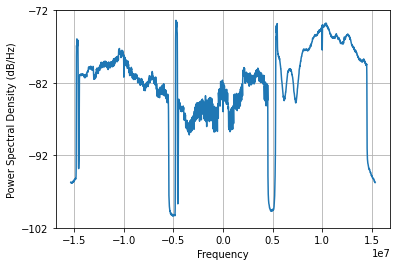

In [374]:
# First the PSD
Pxx, ff = plt.psd(rx[:], Fs=Fs, NFFT=2048)
plt.show()

The PSD indicates that the received signal contains *three* signals of close to 10 MHz bandwidth each. There appear to be additional narrowband signals in the gaps between these signals - the origin and purpose of these signals is not clear. We will take a closer look at each of these signals below.

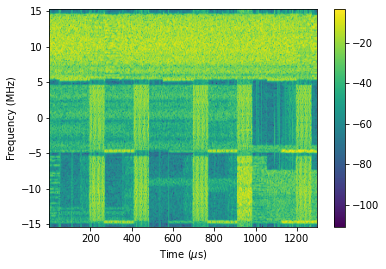

In [375]:
# For the spectrogram, we restrict the duration to about 1ms
# to reveal temporal structures
plt.specgram(rx[:40000], Fs=Fs/1e6)
plt.colorbar()
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Frequency (MHz)')
plt.show()

For an OFDM signal with $\Delta f=$ 15 KHz subcarrier spacing, each symbol is $T_s = \frac{1}{\Delta f}$ (approximately 70 $\mu s$) long. 

The two signals at the bottom of the spectrogram exhibit features that are consistent with this subcarrier spacing. Hence, we can conclude that they are likely OFDM signals.

### Signal Separation and filtering
We have three-frequencies LTE signal, each occupies 9 MHz.

The subcarrier of a downlink LTE signal is 15 KHz.

Therefore, it uses $9 \text{MHz}/15 \text{KHz} = 600$ subcarriers.

Now we extract one of the LTE signal band with the strongest level by first down-convert to baseband and apply a LPF.

Upconverted signal: $r_n = x_n\cdot e^{j 2\pi f_c n/F_s}$

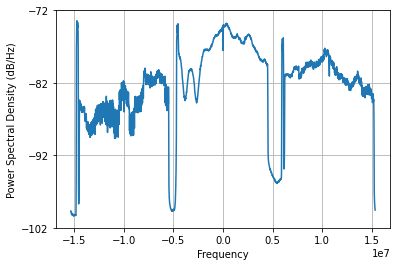

In [376]:
fc = 10e6
rx_unfr = rx*np.exp(-2j*np.pi*fc*np.arange(len(rx))/Fs)

Pxx, ff = plt.psd(rx_unfr, Fs=Fs, NFFT=2048)
plt.show()

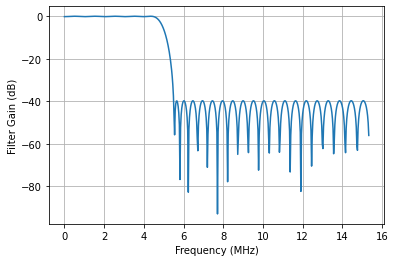

In [377]:
# design an FIR filter with (one-sided) bandwidth 4.5MHz
h = signal.remez(60, [0, 4.5e6, 5.5e6, Fs/2], [1, 0], fs=Fs)
w, H = signal.freqz(h, fs=Fs)

plt.plot(w/1e6, 20*np.log10(np.abs(H)))
plt.grid()

plt.xlabel('Frequency (MHz)')
plt.ylabel('Filter Gain (dB)')

plt.show()

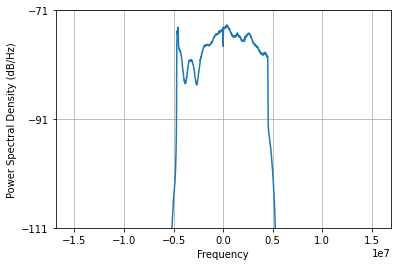

In [378]:
rxf = np.convolve(rx_unfr,h)

Pxx, ff = plt.psd(rxf, Fs=Fs, NFFT=2048)
plt.ylim(-111,-71)
plt.show()

As the signal is more than twice oversampled: 
$F_s/B_w \approx 3$,

We can downsample the signal by 2 to save the signal processing complexity and remove unused subcarriers (10 MHz to 30 MHz -> 10 MHz to 15 MHz).

In [379]:
rxf = rxf[::2]
Fs = Fs//2

# system parameters
N_FFT = Fs//15000
N_CP = 144//2 # normal CP
N_CP_extra = 16//2
half_frame = (Fs*5)//1000 # 5 ms 

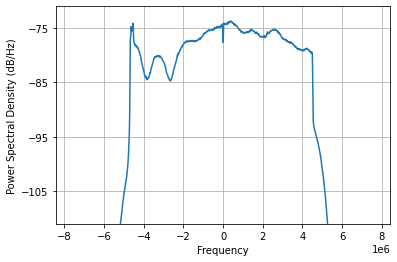

In [380]:
Pxx, ff = plt.psd(rxf, Fs=Fs, NFFT=N_FFT)
plt.ylim(-111,-71)
plt.show()

## What is Where

Before we dive into the details of processing the received signal, we will first orient ourselves where in time and frequency within a frame the various information elements are located. We will refere back to the *resource grid* below frequently.

The resource grid for an LTE FDD frame shows where in time and frequency the signals and channels of interest are located:

![LTE Reource Grid for FDD frames](lte_resource_grid.png)

Towards the goal of isolating and extracting information from the SIB, we will need to process the following signals and channels in the order below:
* **PSS and SSS** for initial synchronization in time and frequency; PSS and SSS also inform the cell id. The PSS always appear in the last symbol of slot 0 and 10 of every frame. The SSS location differs for FDD (frame structure type 1) and TDD (frame structure type 2) frames. For FDD, the SSS signal appears in the symbol immediately before the PSS. For TDD, the SSS appears in the last symbol slots 1 and 11. (TS 36.211, section 6.11)
* **CRS (cell-specific reference signals** are used to provide channel estimates for equalization and transmit diversity (space-time coding). CRS signals are sent in every down-link subframe. Different reference sequences are sent on different resource element from each antenna so that the channel from each TX antenna to the UE can be measured. (TS 36.211, section 6.10.1).
* **PBCH (Physical Broadcast Channel)** The PBCH carries the Master Information Block MIB). It is heavily coded and transmitted in the first four symbols of slot 1. The information in the MIB is repeated over four consecutive frames before it changes (at least the syste frame namber SFN will change). The PBCH uses QPSK modulation and therefore requires equalization and transmit diversity combining using the channel estimates from the CRS. (TS 36.211, section 6.6)  
 *Result:* Contents of Master Information Block (MIB)
* **PCFICH (Physical Control Format Indicator Channel):** This control channel indicates how many symbols in each subframe are allocated for the control channel (PDCCH). The number of symbols for control varies between 1 and 3 in each subframe. This channel indicates which of the three options is used. It is transmitted in the first symbol of every subframe. (TS 36.211, section 6.7)
* **PDCCH (Physical Downlink Control Channel):** contains information about either where a UE may transmit in the uplink direction or where the UE can find either unicast data or broadcast control information (including SIBs) in the down-link direction.  
The PDCCH occupies the first $n$ symbols of every subframes, where $n$ is indicated by the PCFICH. (TS 36.211, section 6.8). Within the PDCCH, the location of Downlink Control Information (DCI) is not fixed. Instead, the UE must search different possibile locations that are enumerated in a search space; it can determine that it has found relevant DCI when demodulation succeeds as indicated by the CRC.  
 *Result:* The UE learns where (in time and frequency) it can received the SIB.
* **PDSCH (Physical Downlink Shared Channel):** The actual SIB is carried on a PDSCH (i.e., a regular taffic channel).

## Task 1: Initial Synchronization

Now that we have isolated a single LTE band, we need to recover the timing of the LTE signal. 

Specifically, we want to identify the location of symbol boundaries and possibly even slot boundaries.

The primary synchronization signal (PSS) and secondary synchronization signal (SSS) are intended for specifically this purpose. 

## Locating the Primary Synchronization Signal

The primary synchronization signal (PSS), together with the secondary synchronization signal (SSS), allows for precise localization of slot and symbol boundaries. It also facilitates accurate frequency error estimation.

The standards document TS 36.211 contains the following about the genration of the PSS:

**6.11.1.1 Sequence generation**

The sequence $d(n)$ used for the primary synchronization signal is generated from a frequency-domain Zadoff-Chu sequence according to
$$
d_u(n) = \begin{cases}
    \exp(-j\frac{\pi u n (n+1)}{63} & \text{ for $n=0,1, \ldots, 30$}\\
    \exp(-j\frac{\pi u (n+1)(n+2)}{63}) & \text{ for $n=31, 32, \ldots 61$}
\end{cases}
$$
where the Zadoff-Chu root sequence index u is given by Table 6.11.1.1-1.

**Table 6.11.1.1-1: Root indices for the primary synchronization signal**

<center>

| $N_{ID}^{(2)}$ | Root Index $u$ |
|:--------------:|:--------------:|
| 0              | 25             |
| 1              | 29             |
| 2              | 34             |

</center>

Note, the parameter $N_{ID}^{(2)}$ is part of the cell ID. Depending on which sequence (i.e., which $u$) is found, we obtain part of the cell ID.

The functions below generates the Zadoff-Chu sequence for a given root index $u$.

In [381]:
def seq_zadoff_chu(u):
    
    n = np.arange(63)
    d_u = np.exp(-1j*np.pi*u*n*(n+1)/63)
    d_u[31] = 0
    
    return d_u

**6.11.1.2 Mapping to resource elements**

The mapping of the sequence to resource elements depends on the frame structure. The UE shall not assume that the primary synchronization signal is transmitted on the same antenna port as any of the downlink reference signals. The UE shall not assume that any transmission instance of the primary synchronization signal is transmitted on the same antenna port, or ports, used for any other transmission instance of the primary synchronization signal.

The sequence $d(n)$ shall be mapped to the resource elements according to 
$$
a_{k,l} =d(n), n=0,\ldots,61 
$$
$$
k = n -31 + \frac{N_{RB}^{DL}N_{sc}^{RB}}{2}
$$

The figure below helps you understand the mapping of PSS:
![Mapping to resource elements for PSS](pss_mapping_to_re.png)

For frame structure type 1 (which corresponds to our case), the primary synchronization signal shall be mapped to the last OFDM symbol in slots 0 and 10.  

The mapping to subcarriers $k$ is reflected in the function below that generates the time-domain PSS. 

In [382]:
def zadoff_chu(u,N_FFT):

    zc = seq_zadoff_chu(u)
    
    # mapping to resource elements
    re = np.zeros(N_FFT,complex)
    re[N_FFT//2-31:N_FFT//2+32] = zc
    
    # return time domain PSS
    return np.fft.ifft(np.fft.ifftshift(re)) 

    # note: either fftshift or ifftshift is applied in freq domain.
    # fft will result in zeros at the original, however you want to move zeros to DC to see symmetric.
    # Therefore, on the contrary, when ifft, you need first to move zeros to the original (as real spectrum be), then do ifft.

### Matching up PSS in data
For every sliding window, correlate with each of the three PSS and compare with a given threshold.

Note, the correlation can be performed in both frequency and time domain. The benefit of computing correlation in the frequency domain is to reduce the computational complexity from N_FFT to the number of symbols. This works more efficiently in matching up SSS since SSS has $168 \cdot 2 = 336$ possible sequences. The downside is that it requires FFTs. 

**In this notebook, the match of PSS and SSS are performed in time domain.**

In [383]:
root_indices = [25,29,34]
zc = {} 

for n in range(len(root_indices)):
    zc[n] = {'u':root_indices[n],'sig':zadoff_chu(root_indices[n],N_FFT)} 

In [384]:
search = False
win = N_FFT
ob_len = len(rxf)//4
max_corr = 0
start = 0
threshold = 0.5

pss_start_set = []
pss_corr_set = []

# The search below finds all PSS that can have a good correlation of 0.6
while win < ob_len:
    
    rx = rxf[win-N_FFT:win]
    
    for n in range(3):
        pss = zc[n]['sig']
        corr = np.abs(np.sum(rx*np.conj(pss))/np.linalg.norm(rx)/np.linalg.norm(pss)) # the two norms can be precomputed
        
        if corr > threshold:
            # The correlation near the pss will decrease not fast. Thus we need to find the peak.
            if corr > max_corr:
                max_corr = corr
                N_id_2 = n
                start = win-N_FFT
            else:
                search = True
    
    if search and corr < threshold:
        pss_start_set.append(start)
        pss_corr_set.append(max_corr)
        max_corr = 0
        search = False
            
    win += 1
    
print('Found the first PSS starting at {:d} with N_id_2 = {:d}, the corr is {:1.2f}'.format(pss_start_set[0],N_id_2,pss_corr_set[0]))

Found the first PSS starting at 132605 with N_id_2 = 0, the corr is 0.55


In [494]:
# select one typical start position of pss to continue our work
print(pss_start_set)
pss_start = pss_start_set[18]

[132605, 286205, 363005, 439805, 593405, 670205, 747005, 900604, 1054204, 1515004, 1668603, 1822203, 1975803, 2129403, 2206203, 2283002, 2590202, 2743802, 2820601, 2897401, 2974201, 3051001, 3204601, 3281401, 3358201, 3511800]


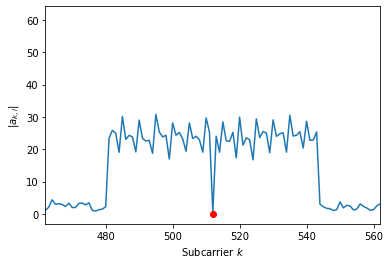

In [386]:
# PSS symbols in freq domain
plt.plot(abs(np.fft.fftshift(np.fft.fft(rxf[pss_start:pss_start+N_FFT]))))

plt.xlim(N_FFT//2-50,N_FFT//2+50) 
plt.plot(N_FFT//2,0,'ro')
plt.xlabel('Subcarrier $k$')
plt.ylabel('$|a_{k,l}|$')
plt.show()

### Computing the frequency offset estimate

 we can also use the detected PSS for frequency offset estimation.

For that purpose, we measure the phase difference over the two halves of the received PSS multiplied by the conjugate of the ZC sequence, so that the phase of the ZC signal is stripped off.

In [387]:
sig = rxf[pss_start:pss_start+N_FFT]
sig_zc = sig*np.conj(zc[N_id_2]['sig'])

pl = np.sum(sig_zc[:N_FFT//2])
pu = np.sum(sig_zc[N_FFT//2:])

f_d = np.angle(pu*np.conj(pl))/(2*np.pi*N_FFT//2) * Fs

f_d

1355.240722455605

## Secondary Synchronization Signal

The secondary synchronization signal (SSS) conveys two pieces of information:
1. it provides the remaining bits of the cell id $N_{ID}$, specifically it conveys $N_{ID}^{(1)}$ which takes on values between 0 and 167.
2. it resolves the remaining unertainty about symbol timing.

A PSS is located in the last OFDM symbol of slots 0 and 10. We cannot know if the PSS we detected was located in slot 0 or in slot 10. The SSS resolves this ambiguity ad therefore allows us to find the frame and subframe boundaries as well.

To convey the information about $N_{ID}^{(1)}$ and timing ambiguity, the SSS contains one of $2 \cdot 168 = 336$ possible sequences.

### Construction of the SSS

There are 336 possible SSS sequences that are constructed in a fairly complex process that involves that is spelled out in detail in section 6.11.2.1 of TS 36.211:

1. combinations and cyclic shifts of three different shift-register sequences (M-sequences)
2. the partial cell id $N_{ID}^{(1)}$ informs the cyclic shifts that are applied to these sequences
3. the combination of sequences is different for SSS in the first and second halves of the frame

The figure below helps you understand the mapping of PSS:
![Mapping to resource elements for SSS](sss_mapping_to_re.png)

We begin our construction with the three shift register sequences; these are denoted $\tilde{s}(n)$, $\tilde{c}(n)$, and $\tilde{z}(n)$ in the standard.

In [388]:
def tilde_s():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+2] ^ x[i] # xor operation
                
    return 1-2.0*x

In [389]:
def tilde_c():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+3] ^ x[i] # xor operation
        
    return 1-2.0*x

In [390]:
def tilde_z():
    
    x = np.zeros(31,dtype=np.uint8)
    x[4] = 1
    for i in range(26):
        x[i+5] = x[i+4] ^ x[i+2] ^ x[i+1] ^ x[i] # xor operation
        
    return 1-2.0*x

The partial cell ID $N_{ID}^{(1)}$ is encoded in shifts of the above sequences via two intermediate variables $m_0$ and $m_1$. These variables are computed from $N_{ID}^{(1)}$ as follows (see section 6.11.2.1 in TS 36.211):
$$
\begin{align}
m_0 & = m^\prime \mod 31 \\
m_1 & = (m_0 + \lfloor m^\prime/31 \rfloor +1) \mod 31\\
m^\prime &= N_{ID}^{(1)} + q(q+1)/2 \\
q & = \left\lfloor \frac{N_{ID}^{(1)} + q^\prime(q^\prime+1)/2}{30} \right\rfloor \\
q^\prime &= \lfloor N_{ID}^{(1)}/30 \rfloor
\end{align}
$$

The function below computes $m_0$ and $m_1$ from $N_{ID}^{(1)}$.

In [391]:
def m_01(N_id_1):
    
    q_prime = N_id_1 // 30
    q = (N_id_1 + q_prime*(q_prime+1)/2) // 30
    m_prime = N_id_1 + q*(q+1)/2
    m_0 = int(m_prime % 31)
    m_1 = int((m_0+m_prime//31+1) % 31)
    
    return (m_0,m_1)

## a spot checks against Table 6.11.2.1-1 in TS 36.211
assert 17,19 == m_01(47)

The final step in the construction of the 336 possible sequences for the SSS is to combine cyclically shifted versions of the shift register sequences. 

The sequences are combined differently for SSS that appear in the first half of a frame (subframes 0 through 4) or the second half (subframes 5 through 9).

The standard specificies that the 62 frequency domain symbols that constitute the SSS are constructed as follows:

The even numbered elements of the SSS are given by:
$$
    d[2n] = \begin{cases}
    s_0^{(m_0)}(n) \cdot c_0(n) & \text{ in subframes $0,1,2,3,4$}\\
    s_1^{(m_1)}(n) \cdot c_0(n) & \text{ in subframes $5,6,7,8,9$}
    \end{cases}
$$

The odd-numbered elements of the SSS are given by:
$$
    d[2n+1] = \begin{cases}
    s_1^{(m_1)}(n) \cdot c_1(n) \cdot z_1^{m_0}& \text{ in subframes $0,1,2,3,4$}\\
    s_0^{(m_0)}(n) \cdot c_1(n) \cdot z_1^{m_1}& \text{ in subframes $5,6,7,8,9$}
    \end{cases}
$$

Above $s_i^{(m)}$, $c_i$, and $z_i^{(m)}$ are cyclic shifts of the shift register sequences $\tilde{s}$, $\tilde{c}$, and $\tilde{z}$, respectively. The code below provides specific details.

We can now generate the 336 SSS sequences. We store the sequences in a dictionary hat is keyed by an index $n$ computed as $n = N_{ID}^{(1)} + 168\cdot F$, where $F=0$ for the first half-frame and $F=1$ for the second half-frame.

In [392]:
def m_sequence(N_id_1,N_id_2,F,N_FFT):
    
    # F: 0 or 1, denoting first half or second half
    
    m_0,m_1 = m_01(N_id_1)
    ts = tilde_s()
    tc = tilde_c()
    tz = tilde_z()
    # print(ts)
    
    c_0 = np.roll(tc,-N_id_2) # left cyclic shift operation 
    c_1 = np.roll(tc,-N_id_2-3) 
    
    s_0 = np.roll(ts,-m_0) 
    s_1 = np.roll(ts,-m_1) 
    
    z_10 = np.roll(tz,-(m_0%8))
    z_11 = np.roll(tz,-(m_1%8))
    
    d = np.zeros(62)
    if F == 0:
        
        d[0::2] = s_0 * c_0
        d[1::2] = s_1 * c_1 * z_10
    elif F == 1:
        
        d[0::2] = s_1 * c_0
        d[1::2] = s_0 * c_1 * z_11
                
    re = np.zeros(N_FFT)
    re[N_FFT//2-31:N_FFT//2] = d[:31]
    re[N_FFT//2+1:N_FFT//2+32] = d[31:]
    
    # return time domain SSS
    return np.fft.ifft(np.fft.ifftshift(re)) 

In [393]:
ms = {}

for N_id_1 in range(168):
    for F in range(2):
        n = N_id_1 + F*168
        ms[n] = {'N_id_1': N_id_1,'F': F,'sig': m_sequence(N_id_1,N_id_2,F,N_FFT)}

### Matching up SSS in data
Correlate with the extracted SSS and selected the one that has the maximum correlation.

Note, this process can be replaced by comparing a threshold as PSS in real-time processing, since the sequence of SSS has very good autocorrelation properties.

In [394]:
sss_start = pss_start - N_CP - N_FFT
sss_in_rx = rxf[sss_start:sss_start+N_FFT] # extract sss
corr = np.zeros(336)

for i,info in ms.items():
    sss = info['sig']
    corr[i] = np.abs(np.sum(sss_in_rx*np.conj(sss))/np.linalg.norm(sss_in_rx)/np.linalg.norm(sss))
    
max_corr_i = np.argmax(corr)
N_id_1 = ms[max_corr_i]['N_id_1']
F = ms[max_corr_i]['F']

print('Found the current slot in the {:s} half frame, with N_id_1 = {:d} and corr = {:1.2f}'.format('first' if F==0 else 'second',N_id_1,corr[max_corr_i]))

Found the current slot in the second half frame, with N_id_1 = 108 and corr = 0.63


#### Decoding the Physical Cell ID (PCI)

The two partial cell IDs $N_{ID}^{(1)}$ and $N_{ID}^{(2)}$ must be combined to yield the phycal cell id (PCI) $N_{ID}^{cell}$. Section 6.11 of TS 36.211 states:

**6.11 Synchronization Signals**

There are 504 unique physical-layer cell identities. The physical-layer cell identities are grouped into 168 unique physical-layer cell-identity groups, each group containing three unique identities. The grouping is such that each physical-layer cell identity is part of one and only one physical-layer cell-identity group. A physical-layer cell identity
$N_{ID}^{cell} = 3N_{ID}^{(1)} + N_{ID}^{(2)}$ is thus uniquely defined by a number $N_{ID}^{(1)}$ in the range of 0 to 167, representing the physical-layer
cell-identity group, and a number $N_{ID}^{(2)}$ in the range of 0 to 2, representing the physical-layer identity within the
physical-layer cell-identity group.


In [395]:
N_id = N_id_1*3 + N_id_2
print('PCI: {:d}'.format(N_id))

PCI: 324


## Preparation: OFDM Demodulation

After successfully performing initial cell search, i.e., matching up with PSS and SSS, **the next decoding of cell system information are all progressed in frequency domain.** 
Thus, we first define an important helper function for translating LTE signal in time domain to frequency domain for OFDM.

#### From TS 36.211: 

**6.12 OFDM baseband signal generation**

The time-continuous signal $s_l^{(p)}(t)$ on antenna port $p$ in OFDM symbol $l$ in a downlink slot is defined by
$$
s_l^{(p)}(t) = \sum_{k=-\lfloor N_{RB}^{DL}N_{sc}^{RB}/2 \rfloor}^{-1} a_{k^{(-)},l}^{(p)} \cdot \exp(j2\pi k \Delta f(t-N_{CP,l}T_s)) +
\sum_{k=1}^{\lceil N_{RB}^{DL}N_{sc}^{RB}/2 \rceil} a_{k^{(+)},l}^{(p)} \cdot \exp(j2\pi k \Delta f(t-N_{CP,l}T_s))
$$
for $0 \leq t < (N_{CP,l} + N) \cdot T_s$ where $k^{(-)} = k+ \lfloor N_{RB}^{DL}N_{sc}^{RB}/2 \rfloor$ and $k^{(+)}=k+\lfloor N_{RB}^{DL}N_{sc}^{RB}/2 \rfloor -1$. The variable $N$ equals 2048 for $\Delta f = 15 \text{KHz}$.

This language implies that:
1. symbols are mapped to subcarriers in increasing order of frequency. Since most FFT libraries compute FFTs for normalized frequencies from 0 to 1, we must use `fftshift` fater taking the FFT of samples.
2. the subcarrier at zero frequency is left empty.
3. Depending on signal bandwidth, $N_{RB}^{DL} \cdot N_{sc}^{RB}$ are occupied. The number of subcarriers per resource block, $N_{sc}^{RB}$ equals 12 for $\Delta f = 15 \text{KHz}$. For the 10MHz signal on hand, $N_{RB}^{DL}$ equals 50.

The function below an be used to extract the information symbols from a received time domain signal for a given $N_{RB}^{DL}$. The signal is assumed to be frequency corrected before it is passed to this function.


In [396]:
def extract_OFDM(ofdm_symbol,N_rb,N_rb_sc=12):
    
    re = np.fft.fftshift(np.fft.fft(ofdm_symbol))
    
    # length of occupied subcarriers
    N_sc = N_rb*N_rb_sc
    N_FFT = len(ofdm_symbol)
        
    # since we want to read the information in REs, we need to skip DC
    active_sc = np.concatenate((np.arange(N_FFT//2-N_sc//2,N_FFT//2),np.arange(N_FFT//2+1,N_FFT//2+N_sc//2+1)))
    
    return re[active_sc]

## Task 2: Decode the MIB

With the frame boundaries established, the next task is to extract the MIB. 

### Pull out samples needed for MIB

The MIB is always transmitted on the PBCH (physical broadcast channel) wihich is found:
* in the first four symbols of the second slot in a frame (for both FDD and TDD)
* on 6 resource blocks (RB), i.e., 72 subcarriers centered at the DC carrier.

The MIB is repeated on four consecutive subframes (for additional error robustness). Hence, the MIB information changes at most every four frames (40ms). It should suffice to process just one such repetition.

To start MIB processing, we first collect the samples for the four blocks containing the PBCH, perform frequency correction, and then convert to the frequency domain.  

In [397]:
pbch_start = pss_start + N_FFT + N_CP + N_CP_extra - F*half_frame # needs to be fit for F later

N_rb = 6
pbch = np.zeros((4,N_rb*12),dtype=complex)

s_pbch = rxf[pbch_start:pbch_start+4*N_FFT+3*N_CP]

s_pbch = s_pbch*np.exp(-2j*np.pi*f_d*np.arange(len(s_pbch))/Fs) # correcting freq offset is necessary

start = 0
for n in range(4):
    pbch[n][:] = extract_OFDM(s_pbch[start:start+N_FFT],N_rb)
    start += N_FFT + N_CP

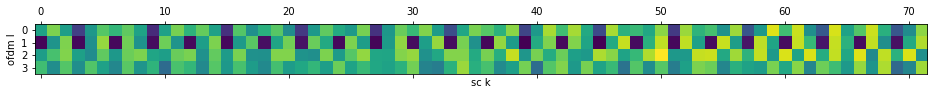

In [398]:
plt.matshow(np.abs(pbch))
plt.xlabel('sc k')
plt.ylabel('ofdm l')
plt.show()
# antenna port 2 is weak.

This looks good! The darker areas indicate unused CRS locations.

## How is the PBCH constructed from the MIB

The MIB carries 24 bits of information which we seek to recover. These bits are processed as follows to produce the $ 4 \cdot 72 = 288$ OFDM symbols we saw above:

1. **CRC** a 16-bit CRC is appanded; that expands the number of bits to 40. (TS 36.212, sections 5.3.1.1 and 5.1.1)
2. **FEC** a rate 1/3 convolutional code is applied to produce 120 coded bits. (TS 36.212, sections 5.3.1.2 and 5.1.3.1)
3. **Rate Matching** the coded bits are permuted, interleaved, and repeated 16 times to yield $16 \cdot 120 = 1920$ coded bits (TS 36.212, sections 5.3.1.3 and 5.1.4.2)
4. **Scrambling** the coded bits are multiplied by a pseudo-random binary sequence to produce 1920 scrambled bits (TS 36.212, section 6.6.1)
5. **Modulation** the scrambled bits are mapped to $1920/2=960$ QPSK symbols (TS 36.212, sections 6.6.2 and 7.1)
6. **Layer Mapping and Precoding** A space-time code is applied to provide transmit diversity. This involves generating signals for multiple antennas (layers). The mapping depnds on the number of antennas (1, 2, or 4) - which is unknown at this point (signaled by MIB). Hence, all three possibilities should be attempted. This does not change the number of symbols. (TS 36.211, sections 6.6.1 and 6.3.4.1 or 6.3.4.3 depending on number of antennas)
7. **Demultiplexing** The 960 symbols are split over four consecutive frames (240 symbols per frame) and placed in resource elements that are not occupied by CRS (reference signals). There are 48 resource elements occupied by CRS in the area occupied by the PBCH for a total of $240+48=288$ resource elements. (TS 36.211, section 6.6.4)

To recover the MIB we must process the PBCH in the reverse order of these steps:

1. **CRS** we must extract the cell-specific reference signals from the received signal and form estimates of the channel's frequency responses from each transmit antenna to the receiver.
2. **Transmit Diversity Combining/Equalization** Based on the channel estimates obtained via the CRS, the received signal must be equalized to compensate for the frequecy response. In the case of multiple antennas, transmit diversity combining must be applied. At the end of this process, we should have clean QPSK symbols.
3. **Demodulation** The QPSK symbols are demodulated to form bit decisions.
4. **Descrambing** The bit decisions are descrambled.
5. **Rate Matching** The re-ordering and repetitions applied during rate-matching are undone to yield 120 inputs for the FEC decoder.
6. **Decoding** The bit decisions are decoded using a Viterbi Decoder.
7. **Check CRC** Verify the CRC; this also confirms the number of transmit antennas.

## Preparation: Cell-Specific reference sequences (CRS)

CRS are used to estimate the channel between transmit antennas and the receivers in the frequency domain. They are located throughout the resource grid as specified in TS 36.211 section 6.10.1. 



### CRS Sequence Generation

The complex symbols used as the CRS signal are generated as specified in TS 36.211, section 6.10.1.1

The reference-signal sequence $r_{l,n_s}(m)$ is defined by
$$
r_{l,n_s}(m)= \frac{1}{\sqrt{2}} (1−2c(2m))+ j \frac{1}{\sqrt{2}} (1−2⋅c(2m+1)), \quad m=0,1,\ldots,2N_{RB}^{max,DL} −1
$$
where $n_s$ is the slot number within a radio frame and $l$ is the OFDM symbol number within the slot. The pseudo-
random sequence $c(i)$ is defined in clause 7.2. The pseudo-random sequence generator shall be initialised with 
$c_{init} =2^{10} \cdot (7⋅(n_s'+1)+l+1)\cdot(2⋅N_{ID}^{cell} +1)+2\cdot N_{ID}^{cell} + N_{CP}$ at the start of each OFDM symbol where
$$
n_s' = \begin{cases}
10 \cdot \lfloor n_s/10\rfloor  + n_s \mod 2 & \text{for framestructure type 3 when the CRS is part of a DRS}\\
n_s & \text{otherwise}
\end{cases}
$$
$$
N_{CP} =
\begin{cases}
1 & \text{for normal CP}\\
0 & \text{for extended CP}
\end{cases}
$$

The reference signals $r_{l,n_s}(m)$ are generated from pseudo-random binary sequences (TS 36.211, section 7.2):

Pseudo-random sequences are defined by a length-31 Gold sequence. The output sequence $c(n)$ of length $M_{PN}$ , where $n=0,1,\ldots,M_{PN} −1$,is defined by
\begin{align*}
c(n) & = (x_1 (n + N_C ) + x_2 (n + N_C )) \mod 2\\
x_1 (n + 31) & = (x_1 (n + 3) + x_1 (n)) \mod 2\\
x_2 (n + 31) & = (x_2 (n + 3) + x_2 (n + 2) + x_2 (n +1) + x_2 (n)) \mod 2
\end{align*}
where $N+C =1600$ and the first m-sequence shall be initialized with $x_1(0)=1$, $x_1(n)=0$, $n=1,2,\ldots,30$.The initialization
of the second m-sequence is denoted by $c_{init} = \sum_{i=0}^{30} x_2(i) \cdot 2^i$ with the value depending on the application of the
sequence.

The functions below provide a (not very efficient) implementation of the generator for these sequences. 

In [399]:
# TS 36.211, 7.2
def c_sequence(M,c_init,Nc=1600):
    
    # M: required length of c sequence.
    # binary operation. The total required length of x_1 is M+Nc
    x_1 = np.zeros(M+Nc,dtype=np.uint8)
    x_1[0] = 1
    for n in range(31,M+Nc):
        x_1[n] = x_1[n-28] ^ x_1[n-31]
        
    x_2 = np.zeros(M+Nc,dtype=np.uint8)
    for n in range(31):
        x_2[n] = (c_init & (1<<n)) >> n # bitwise operator
    for n in range(31,M+Nc):
        x_2[n] = x_2[n-28] ^ x_2[n-29] ^ x_2[n-30] ^ x_2[n-31]
    
    return x_1[Nc:] ^ x_2[Nc:]    

The function below generates reference signals $r_{l,n_s}(m)$ for a given slot number $n_s$, slot number $l$, cell id $N_{ID}^{cell}$ and indicator for the length of the cyclic prefix. 

These sequence are of length $N_{RB}^{max,DL} = 110$ (TS 36.211, section 6.2.1).

In [400]:
# TS 36.211, 6.10.1.1
def crs_sequence(ns,l,N_id,N_cp=1,N_rb_max=110):
    
    # ns: slot number.
    # l: OFDM symbol number
    
    c_init = 2**10*(7*(ns+1)+l+1)*(2*N_id+1)+2*N_id+N_cp
    c = c_sequence(4*N_rb_max,c_init)
    
    return np.sqrt(0.5)*((1-2.0*c[0::2]) + 1j*(1-2.0*c[1::2]))

### Where do the CRS symbols appear

TS 36.211, section 6.10.1.2 specifies the mapping of CRS symbols to resource elements:

The reference signal sequence $r_{l,n_s}(m)$ shall be mapped to complex-valued modulation symbols $a_{k,l}^{(p)}$ used as reference
symbols for antenna port $p$ in slot $n_s$ according to
$$
a_{k,l}^{(p)}=r_{l,n_s}(m')
$$
where
$$
k = 6m+(\nu+\nu_{shift}) \mod 6
$$
$$
l = \begin{cases}
0, N_{symb}^{DL} - 3 & \text{ if $p \in \{0,1\}$}\\
1 & \text{ if $p \in \{2,3\}$}\\
\end{cases}
$$
$$
m=0,1,...,2 \cdot N_{RB}^{DL} −1
$$
$$
m'=m+N_{RB}^{max,DL} −N_{RB}^{DL}
$$
The variables $\nu$ and $\nu_{shift}$
define the position in the frequency domain for the different reference signals where $\nu$ is
$$
\nu = 
\begin{cases}
0 & \text{if $p=0$ and $l=0$}\\
3 & \text{if $p=0$ and $l\neq 0$}\\
3 & \text{if $p=1$ and $l=0$}\\
0 & \text{if $p=1$ and $l\neq 0$}\\
3 \cdot (n_s \mod 2) & \text{if $p=2$}\\
3 + 3 \cdot (n_s \mod 2) & \text{if $p=3$}
\end{cases}
$$
The cell-specific frequency shift is given by $\nu_{shift} = N_{ID}^{cell} \mod 6$.

The figure below helps you understand the CRS position in one subframe:
![CRS position in one subframe](crs_in_one_subframe.png)


Resource elements (k,l) used for transmission of cell-specific reference signals on any of the antenna ports in a slot shall not be used for any transmission on any other antenna port in the same slot and set to zero.

**Notes:**
* CRS sequences are transmitted on all active antennas.
* The CRS locations for different antennas do not overlap - when a CRS symbol is sent, only one antenna is active.
* Each antenna's CRS signal appears on every sixth subcarrier
* Location and content of CRS is cell specific
* With respect to the MIB, relevant CRS locations are in the first symbol (for antenas 0 and 1) or the second symbol (antennas 2 and 3).
* The terminal assumes a cell bandwidth equal to the minimum possible downlink bandwidth (center 6 RB) to determine the value of CRS at positions.

The function below generates the CRS symbols and the corresponding frequency locations $k$ where these symbols appear for all four antennas.

In [401]:
# TS 36.211 6.10.1.2, note figure.
def crs_in_re(p,l,ns,N_id,N_rb,N_rb_max=110):
    
    # p: antenna port number
    # l: OFDM symbol number
    # ns: slot number
    
    nu = -1
    if p == 0 and l == 0:
        nu = 0
    elif p == 0 and l == 4:
        nu = 3
    elif p == 1 and l == 0:
        nu = 3
    elif p == 1 and l == 4:
        nu = 0
    elif p == 2 and l == 1: 
        nu = 3*(ns%2) 
    elif p == 3 and l == 1:
        nu = 3 + 3*(ns%2) 
        
    if nu == -1:
        return (None,None)
        
    nu_shift = N_id % 6
    
    cs = crs_sequence(ns,l,N_id)
    
    m = np.arange(2*N_rb)
    m_prime = m + N_rb_max - N_rb
    crs = cs[m_prime] # value of crs
    
    k = 6*m + (nu + nu_shift) % 6 # index of crs
    
    return (k,crs) 

### Estimating channel responses for PBCH by CRS

In [402]:
ns = 1

h_pbch = np.zeros((4,N_rb*12),dtype=complex)
for p in range(4):
    if p < 2:
        l = 0
    else:
        l = 1
    
    k,crs = crs_in_re(p,l,ns,N_id,N_rb)
    h_pbch[p][k] = pbch[l][k] * np.conj(crs)

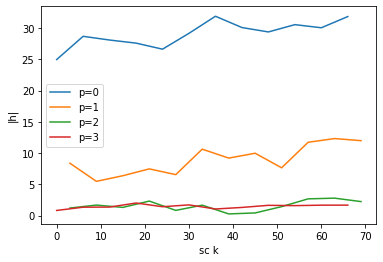

In [403]:
for p in range(4):
    if p < 2:
        l = 0
    else:
        l = 1
    k,crs = crs_in_re(p,l,ns,N_id,N_rb)
    plt.plot(k,np.abs(h_pbch[p][k]),label='p={:d}'.format(p))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.legend()
plt.show()

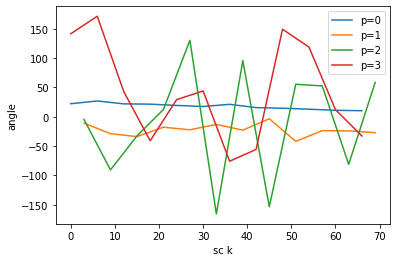

In [404]:
for p in range(4):
    if p < 2:
        l = 0
    else:
        l = 1
    k,crs = crs_in_re(p,l,ns,N_id,N_rb)
    plt.plot(k,np.angle(h_pbch[p][k])*180/np.pi,label='p={:d}'.format(p))
    
plt.xlabel('sc k')
plt.ylabel('angle')
plt.legend()
plt.show()

As suggested together by magnitudes and phases, it appears that only two antennas are active.

### Interpolate Frequency Response Estimates

To conclude processing of the CRS, we interpolate the frequency response estimate to all 72 subcarriers that hold the PBCH. To do so, we use the closest (in $k$) estimate.

In [405]:
for p in range(4):
    if p < 2:
        l = 0
    else:
        l = 1
        
    k,crs = crs_in_re(p,l,ns,N_id,N_rb)
    for kk in range(72):
        n = k[np.argmin(np.abs(k - kk))]
        h_pbch[p][kk] = h_pbch[p][n]

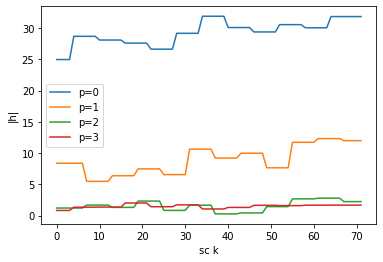

In [406]:
for p in range(4):
    if p < 2:
        l = 0
    else:
        l = 1
        
    plt.plot(np.abs(h_pbch[p]),label='p={:d}'.format(p))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.legend()
plt.show()

### Extract the MIB Symbols and Its Channel Estimate

TS 36.211, section 6.6.4 specifies that any resource element that could be used for CRS must be skipped. Otherwise, PBCH symbols are mapped to resource elements in frequency-first order.

Along with the symbols we also store the estimates of the frequency response.

Note, we only focus on the case that 2 antennas are used. In real-time processing, a *blind search* should be performed to try for different numbers of antennas in transmit diversity combining at the first time.

In [407]:
tmp0 = np.zeros((4,72),complex)
tmp1 = np.zeros((4,72),complex)

# define mask for positions of CRS
ex_index = np.arange(0,72,3)
mask = np.ones(72, dtype=bool)
mask[ex_index] = False

r_pbch = np.array([], dtype=complex)
h0_pbch = np.array([], dtype=complex)
h1_pbch = np.array([], dtype=complex)

for l in range(4):
    # intepolate in time domain
    tmp0[l,:] = h_pbch[0]
    tmp1[l,:] = h_pbch[1]
    
    if l < 2:
        r_pbch = np.concatenate((r_pbch,pbch[l][mask]))
        h0_pbch = np.concatenate((h0_pbch,tmp0[l][mask]))
        h1_pbch = np.concatenate((h1_pbch,tmp1[l][mask]))

    else:
        r_pbch = np.concatenate((r_pbch,pbch[l]))
        h0_pbch = np.concatenate((h0_pbch,tmp0[l]))
        h1_pbch = np.concatenate((h1_pbch,tmp1[l]))

### Transmit Diversity Combining

We will process the signal under the assumption that **two** transmit antennas were used. In that case, information is encoded with a Space-Time Code (STC) that provides transmit diversity by utilizing propagation paths from two different antennas. This code is known as an *Alamouti* code.

If only a single antenna were used, then no space-time code is applied. With four antennas, a similar STC is used. 

The STC for two (and four antennas) is described in section 6.3.4.3 of TS 36.211. Below is a more concise description of the code in terms of complex symbols. The code is 

The code transmits two consecutive symbols $x[2n]$ and $x[2n+1]$ simultaneously over two antennas using two transmit symbols $y^{(p)}[2n]$ and $y^{(p)}[2n+1]$ for each antenna $p$. The transmited symbols are constructed as follows:
$$
\begin{aligned}
y^{(0)}[2n] &= x[2n] & \quad & y^{(0)}[2n+1] & = x[2n+1] \\
y^{(1)}[2n] &= -x^*[2n+1] & \quad & y^{(1)}[2n+1] & = x^*[2n] 
\end{aligned}
$$
Note that each symbol is sent (in some form) on each antenna and for each $n$.

The received signal will be the superposition of the signals from the two antennas. If we denote by $H_p$ the frequency response from the $p$-th antenna to the receiver then the received signal is:
$$
r[n] = H_0 \cdot  y^{(0)}[n] + H_1 \cdot  y^{(1)}[n] + N_n.
$$

It can be shown, that optimal estimates for the symbols $x[n]$ are given by:
$$
x[2n] = \frac{1}{|H_0|^2 + |H_1|^2} \cdot (H_0^* \cdot r[2n] + H_1 \cdot r^*[2n+1])
$$
and 
$$
x[2n+1] = \frac{1}{|H_0|^2 + |H_1|^2} \cdot (-H_1^* \cdot r[2n] + H_0 \cdot r^*[2n+1])^*
$$
Note that this operation performs both equalization and combining of the signals from the two antennas.

The function below performs the combining operation for two received symbols and the correspond frequency responses.

In [408]:
def Alamouti_combine(r,H0,H1):
    "perform combing of two symbols for an Alamouti STC"
    scale = abs(H0[0::2])**2 + abs(H1[1::2])**2
    d = np.zeros_like(r)

    d[0::2] =  (H0[0::2].conjugate() * r[0::2] + H1[1::2] * r[1::2].conjugate()) / scale
    d[1::2] = ((-H1[0::2].conjugate() * r[0::2] + H0[1::2] * r[1::2].conjugate()) /scale).conjugate()

    return d

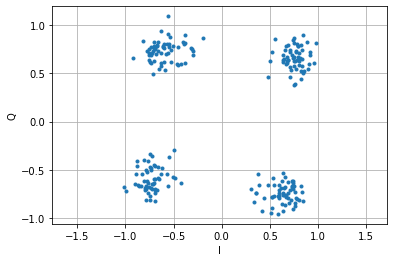

In [409]:
x_pbch = Alamouti_combine(r_pbch,h0_pbch,h1_pbch)

plt.plot(x_pbch.real,x_pbch.imag,'.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

### Demodulation

In the next step, we demodulate the QPSK symbols. Since the received signal appears very clean, we settle for hard decision decoding.

According to section 7.1.2 in TS 36.211, the QPSK modulator maps the first modulated bit to the polaruty of the I-channel and the second bit to the Q-channel.

In [410]:
def qpsk_demodulate(x):
    "QPSK demodulate a sequence of observation"
    b = np.zeros(2*len(x), dtype=np.uint8)

    for n in range(len(x)):
        b[2*n] = 0 if np.real(x[n]) > 0 else 1
        b[2*n+1] = 0 if np.imag(x[n]) > 0 else 1

    return b

In [411]:
pbch_scrambled_bits = qpsk_demodulate(x_pbch)

pbch_scrambled_bits.size

480

### Scrambling

Section 6.6.1 of TS 36.211 specifies that the FEC encoded and rate-matched MIB is to be scrambled with a pseudo-random sequence.

The block of bits $b(0),\ldots,b(M_{bit} −1)$ , where $M_{bit}$, the number of bits transmitted on the physical broadcast channel,
equals 1920 for normal cyclic prefix and 1728 for extended cyclic prefix, shall be scrambled with a cell-specific
sequence prior to modulation, resulting in a block of scrambled bits $\tilde{b}(0),\ldots,\tilde{b}(M_{bit} −1)$ according to 
$$
\tilde{b}(i) = (b(i) + c(i)) \mod 2
$$
where the scrambling sequence $c(i)$ is given by clause 7.2. The scrambling sequence shall be initialised with
$c_{init} = N_{ID}^{cell}$ in each radio frame fulfilling $n_f \mod 4 = 0$.

The scrambling sequence is generated from the same pseudo-random genarator as the CRS (see `c_sequence` above.)

A complication arises because we observe only a quarther of the 1920 bits that represent the MIB in each frame. So, the bits we're processing here could be scrambled by any of four possible segments of the scrambling sequence.

We have to try (and carry forward) all four possibilities and figure out the right piece for performing de-scrambling. As shown later in rate matching, the recovered bits within the right piece of MIB will be repeated every 120 bits. We can figure out the right piece based on this metric. 

In [412]:
c = c_sequence(1920,N_id)
n_bits = len(pbch_scrambled_bits)
threshold = 0.95

for rv in range(4):
    pbch_bits = pbch_scrambled_bits ^ c[rv*n_bits:(rv+1)*n_bits]
    if np.sum(pbch_bits[:120] == pbch_bits[120:240])/120 > threshold:
        print('The decoding MIB is from the redundency version {:d}'.format(rv))
        break

The decoding MIB is from the redundency version 2


### Rate Matching

The FEC coded bits are interleaved, permuted and rate matched as specified in section 5.1.4.2 of TS 36.212. Figure 5.1.4-2 from TS 36.212 is replicated below.

![Rate Matching](rate_matching.png)

First three coded blocks of 40 bits each from the convolutional coder are interleaved individually using a subblock interleaver specified in section 5.1.4.2.1 of TS 36.212. 

These blocks are concatenated and then repeated until 1920 bits have been generated. Specifically, the coded and interleaved blocks - consisting of 120 bits -  are simply repeated 16 times to generate 1920 bits. A quarter of these bits (480) appear in a single PBCH block. Put differently, in a single PBCH the coded and interleaved bits are repeated four times.

In order to reverse the process of rate matching, we focus on conducting the permutation index through the rate matching for PBCH.

#### Subblock Interleaver

We implement the subblock interleaver by creating an indexing table to permute blocks of 40 bits. 

To begin constructing the permutation table, we need the subblock interleaver. 

According to section 5.1.4.2.1, the subblock interleaver is a block interleaver:
* If the number of bits is not a multiple of $C=32$, they are padded (at the front) with `NULL` dummy bits that are later removed.
* A block of bits is read row-wise into a matrix with $C=32$ rows, 
* the rows are permuted using a given pattern, 
* finally bits are read out column-wise. 

According to section 5.1.4.2.2 of TS 36.212, the three coded and interleaved blocks are:
* concatenated,
* the `NULL` dummy bits are removed.

The function below computes the permuted indexes of subblock interleaver by given the original index (0,1,2,...,N-1)  

In [413]:
def subblock_interleaver(seq,col_perm_table):
    "subblock interleaving of coded streams"
    N_cc = 32    
    D = len(seq)
    
    DUMMY = D+10000

    R = D // N_cc
    if R * N_cc < D:
        R = R + 1
        
    # prepend dummy symbols, these 
    N_dummy = R*N_cc - D
    y = np.concatenate( (DUMMY *np.ones(N_dummy, dtype=seq.dtype), seq) )

    # read row-wise into a matrix
    M = np.reshape(y, (R, N_cc))
    
    # permute the columns of the matrix
    P = np.zeros_like(M)
    for n in range(N_cc):
        P[:, n] = M[:, col_perm_table[n]]

    # transpose and reshape P to give the output vector
    v = np.reshape(P.T, -1)

    # remove the dummy symbols
    e = v[v != DUMMY]

    return e

In [414]:
# the table for permuting columns of the matrix are given in TS 36.212,  Table 5.1.4-1
col_perm_table = np.array([1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31, 
                           0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30])

## construct the permutation table
ind  = np.arange(40)                   # indices 0 to 39
perm_table = subblock_interleaver(ind,col_perm_table) # pass indices to interleaver to obtain the permutation table

perm_table

array([ 9, 25, 17,  1, 33, 13, 29, 21,  5, 37, 11, 27, 19,  3, 35, 15, 31,
       23,  7, 39,  8, 24, 16,  0, 32, 12, 28, 20,  4, 36, 10, 26, 18,  2,
       34, 14, 30, 22,  6, 38])

#### Bit collection and selection
According to section 5.1.4.2.2 of TS 36.212, the bit collection in the circular buffer is straightforward by collecting the coded bits from the subblock interleaver in the order of subblock 0, subblock 1, subblock 2.

The selection of bits from the circular buffer is also straightforward by keeping selecting *available bits* from the very first bits (0th bits of subblock 1).

Thus, the reverse operation can be easily operated as follows

In [415]:
pbch_coded_bits = np.zeros((3,40),dtype=np.uint8)

for n in range(3):
    pbch_coded_bits[n,perm_table] = pbch_bits[n*40:(n+1)*40] 
    
pbch_coded_bits    

array([[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]],
      dtype=uint8)

### FEC Decoding

Forward error correction (FEC) coding for the PBCH is performed according to TS 26.212, section 5.1.3.1. The operation of the coder is summarized in Figure 5.1.3-1 which is replicated below.

![Figure 5.1.3-1: Rate 1/3 tail biting convolutional encoder](convolutional_coder.png)

This is a *tail-biting* convolutional code; i.e., the initial state of the encoder is given by the last six bits of the information sequence $c_k$.

#### MLSE Decoding

Optimal decoding is performed by *Maximum Likelihood Sequence Estimation* using the Viterbi Algorithm.

The algorithm tracks all possible sequences of bits $c_k$ and identifies the one that produces outputs $d^{(i)}_k$ that are most similar to the received bits we obtained from the de-interleaver.

The "trick" in the Viterbi algorithm is to prevent an exponential explosion of the search space (there are $2^{40}$ possible sequences) by realizing that the shift register in the encoder imposes constraints that can be leveraged to design a recursive algorithm that requires only $2^7$ operations per bit.

The class below provides a Viterbi decoder and encoder. It pre-computes tables of possible outputs for given register contents and "new" input bits. The `decode` function iterates over the elements of a received sequence of bits, updates accumulated cost (errors), and tracks "surviving" sequences.

First, we need a few helper functions to implement the shift register circuits.

In [416]:
# helper function: count the number of 1-bits in an integer
def count_ones(n):
    "count the number of 1-bits in an integer"
    b = 0
    while n != 0:
        b += n & 0x1
        n = n >> 1

    return b

# helper function to find the total number of bits in an integer
def count_bits(n):
    "count the number of 0 and 1-bits in an integer"
    b = 0
    while n != 0:
        b += 0x1
        n = n >> 1

    return b

def hamming_dist(obs, ref):
    "Compute the Hamming distance between two sequences of integers"
    return np.sum( ref != obs)

The basic idea of implementing Viterbi algorithm is listed as follows:
1. Define a 2-D grid: row: states, column: time.
2. Define and work with current states, previous states and input bits from previous states to current states.
3. For each input bit (0 or 1) at a certain current state, compute two path metrics and add up with the cost of previous states to get two cost of current states. Select the smaller one for each current states.
4. Update cost and store input.
5. At the end, choose the input sequence (one row) with the smallest cost.

In [417]:
class ConvCoder(object):
    "Class to implement convolution FEC coding"
    
    def __init__(self, generators_list):
        """The convolutional code is described by a list of generator polynomials. Each 
        generator polynomial is summarized by an integer that captures the connections from
        the shift register to the coded bits.
        
        From the generators, the structural properties of the code can be deduced:
        * the number of bits in the generators determines the length of the shift register
        * the number of generators determines the code rate

        The standard specifies three specific generators (`0o133`, `0o171`, and `0o165`) 
        for a rate 1/3 code with a constraint length of 6 delays in the shift register. 
        This implementation is generic and supports arbitrary generators.
        """
        self.n_codes = len(generators_list)
        self.order = max([count_bits(n) for n in generators_list]) - 1
        self.generators = generators_list

        self.Nt = 2 ** (self.order + 1) # number of prossible outputs in each bit period
        self.Ns = 2 ** self.order       # number of states of the shift register

        # table of possible outputs
        self._t = np.empty((self.Nt, self.n_codes), dtype=np.uint8)
        for n in range(self.Nt):
            # loop over all possible bit patterns of length order+1
            for m in range(self.n_codes):
                self._t[n, m] = count_ones(n & self.generators[m]) & 0x1

    def decode(self, d, cost_fun):
        """Decode a sequence of observations using the Viterbi algorithm
        
        Inputs:
        * d - 2D array of observations; leading dimension must be equal to self.n_codes
        * cost_fun - function to measure similarity; use `Hamming_dist` for hard decision observations,
                     and `L2_dist` for soft decisions

        Returns:
        vector of bits; length is equal to the second dimension of `d`
        """
        assert d.shape[0] == self.n_codes, "Leading dimension of d must match number of generators"

        # initialization
        N = d.shape[1]             # number of input observations; also number of outputs
        costs = np.zeros(self.Ns)  # accumulated similarity metric
        # sequences of estimated bits; one for each register state
        survivors = 127 * np.zeros([self.Ns, N], dtype=np.uint8)

        for n in range(N):
            # temporary storage for the following loops; these are updated during the first phase
            # and then copied to the permanent variables in the second phase. This is needed
            # to prevent that intermediate results are overwritten prematurely
            tmp_cost = np.inf * np.ones(self.Ns)
            # tmp_ts = np.zeros(self.Ns, dtype=np.uint8)
            tmp_b = np.zeros(self.Ns, dtype=np.uint8)
            tmp_survivors = survivors[:, :n].copy()  # this copy is critical - grrrr
            
            obs = d[:, n]  # outputs for this bit period

            # update costs and survivor extensions; the key to the algorithm is
            # that there are possible 2^7 bit patterns in each bit period. The 6 most
            # significant bits form the state at the end of the bit period. The 6 least
            # significant bits define the state at the start of the period. Hence, there
            # are only two possible beginning states to reach an end state. For each end state
            # we only keep the path that with the smaller cost metric. 
            for te in np.arange(self.Ns, dtype=np.uint8):
                # loop over all states at the end of this bit period
                for b in np.arange(2, dtype=np.uint8):
                    # loop ver the LSB of the beginning states; this is the 
                    # only bit that's not also in te
                    # b is the LSB of t and ts
                    t = (te << 1) + b      # t combines the bits of ts and te 
                    ts = t & (self.Ns - 1) # state at the start of period
                    # compute cost recursively: cost at the start of the priod +
                    # cost associated with the difference betwee observation and
                    # coded bits for this transition from ts to te
                    c = costs[ts] + cost_fun(obs, self._t[t, :])
                    #if n == 1 and c == 0:
                    #    print(te, t, ts, c, survivors[ts, :n])
                    if c < tmp_cost[te]:
                        # store results if this is the lowest cost path to te
                        tmp_cost[te] = c
                        # capture the MSB of t (and te); that's the current bit
                        tmp_b[te] = (t & self.Ns) >> (self.order)
                        # tmp_ts[te] = ts
                        tmp_survivors[te, :] = survivors[ts, :n]

            # copy the updates to permanent variables for next iteration
            for te in np.arange(self.Ns, dtype=np.uint8):
                costs[te] = tmp_cost[te]
                survivors[te, :n] = tmp_survivors[te, :]
                survivors[te, n] = tmp_b[te]

                #if n == 1 and costs[te] == 0:
                #    print(te, tmp_ts[te], tmp_b[te], tmp_survivors[te, :], survivors[te, :n+1])
                
        # all done, find the lowest cost and return the corrponding survivor
        ind_survivor = np.argmin(costs)
        return survivors[ind_survivor, :], costs[ind_survivor]


    def encode(self, bits, init_state=None):
        """convolutional encoder
        
        Inputs:
        bits - information bits to be encoded
        init_state - initial state for the register (default: initialize via tail-biting; i.e., 
        use last elements of bits)

        Returns:
        2D - array of coded bits; leading dimension equals the number of generators, second
             dimension equals the number of bits
        """
        d = np.zeros((self.n_codes, len(bits)), dtype=np.uint8)

        # initialize state; default via tailbiting
        ts = np.uint8(0)
        if init_state is None:
            for n in range(self.order):
                ts += (bits[-(n+1)] << (self.order - n -1))
        else:
            ts[:] = init_state[:]
        
        # print("Initial state: {:06b}".format(ts))

        # Encoder
        for n in range(len(bits)):
            # construct transition t from state ts and next bit
            t = ts + (bits[n] << self.order)
            # look up output in table
            d[:,n] = self._t[t, :]
            # update state
            ts = (t >> 1)
            
            #print("n = {:d} - bit = {:d} state = {:06b} ({:d} {:d} {:d})".format(n, bits[n], ts, d[0,n], d[1,n], d[2,n]))

        return d     

In [418]:
# check the accuracy of convolutional coder and decoder
fec = ConvCoder([0o133, 0o171, 0o165])

test_mib = np.random.randint(0, 2, size=40)
coded_mib = fec.encode(test_mib)

decoded, cost = fec.decode(coded_mib, hamming_dist)

if cost == 0.0 and  np.sum(test_mib != decoded) == 0:
    print('Hard decsion: OK')
else:
    print('Hard decision: cost = {:f}, {:d} errors'.format(cost, np.sum(test_mib != decoded)) )

Hard decsion: OK


#### One more thing: Tail-biting

The length of the MIB bits is usually sufficient to produce a correct decoding. However, it is possible that the effect of initializing the state of the coder with the trailing 6 bits is not completely eliminated after 40 bits.

To circumvent any issues related to initialization, it is recommended practice with tail-biting to pass the observed sequence through the decoder twice and select the first half of decoded bits from the second pass and the second half of decoded bits from the first pass.

In [419]:
## decode for tail-biting
# pass two copies of received coded bits trough the decoder
decoded_2x, cost = fec.decode(np.concatenate((coded_mib, coded_mib), axis=1), hamming_dist)

# collect first 20 from second half and second 20 from first half
decoded = np.concatenate( (decoded_2x[40:60], decoded_2x[20:40]) )

# check
if cost == 0.0 and  np.sum(test_mib != decoded) == 0:
    print('Tail-biting: OK')
else:
    print('Tail-biting: cost = {:f}, {:d} errors'.format(cost, np.sum(test_mib != decoded)) )

Tail-biting: OK


### Decoding the PBCH bits

In [420]:
pbch_hard_bits_2x,cost = fec.decode(np.concatenate((pbch_coded_bits,pbch_coded_bits),axis=1),hamming_dist)
pbch_hard_bits = np.concatenate((pbch_hard_bits_2x[40:60],pbch_hard_bits_2x[20:40])) # to avoid choosing the first 20 and the last 20

print('cost: {:1.0f}, hard bits: {:}'.format(cost,pbch_hard_bits))

cost: 0, hard bits: [0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 0 1]


### Cyclic Redundancey Check (CRC)

Attachment of the CRC to the bits of the MIB is specified in TS 36.212, section 5.3.1.1:

Error detection is provided on BCH transport blocks through a Cyclic Redundancy Check (CRC).

The entire transport block is used to calculate the CRC parity bits. Denote the bits in a transport block delivered to layer
1 by $a_0, a_1, a_2, a_3, \ldots , a_{A −1}$, 
and the parity bits by
$p_0, p_1, p_2, p_3, \ldots , p_{L −1}$. 
$A$ is the size of the transport block and set to 24 bits and $L$ is the number of parity bits. 
The lowest order information bit $a_0$ is mapped to the most significant bit of
the transport block as defined in subclause 6.1.1 of TS 36.321.

The parity bits are computed and attached to the BCH transport block according to subclause 5.1.1 setting $L$ to 16 bits. After the attachment, the CRC bits are scrambled according to the eNodeB transmit antenna configuration with the sequence $x_{ant,0},x_{ant,1},\ldots,x_{ant,15}$ as indicated in Table5.3.1.1-1to form the sequence of bits $c_0,c_1,c_2,c_3,\ldots,c_{K−1}$ where
\begin{align*}
c_k &= a_k \text{ for $k=0,1,2,\ldots,A-1$}\\
c_k & = (p_{k−A} + x_{ant,k−A} ) \mod 2 \text{ for $k = A, A+1, A+2, \ldots, A+15$.}
\end{align*}

The scrambling sequences $x_{ant,k}$ depend on the number of antenna ports $N_{ant}$:
* if $N_{ant}=1$, then all elements of $x_{ant,k}$ equal 0
* if $N_{ant}=2$, then all elements of $x_{ant,k}$ equal 1
* if $N_{ant}=4$, then elements of $x_{ant,k}$ alternate between 0 and 1.

This information is used to determine the number of antennas conclusively.

The CRC polynomial that is used for the PBCH is given in section 5.1.1 of TS 36.212. For the PBCH, a 16-bit CRC is used and it's polynomial is
$$
g_{CRC16}(D)=[D^{16} +D^{12} +D^5 +1]
$$
The coefficients of this polynomial are, therefore, equal to $[1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1]$. It is customary to omit the leading cefficent (which is always 1) in the packed (hexadecimal) representation of the polynomial, so that this polynomial is concisely summarized as `0x1021`.

The parity bits are computed, as usual, by dividing the polynomial generated from the data (i.e., the MIB bits in our case) by the generator polynomial.

The class below implements Sarwate's table-driven approach to compute the CRC.

In [421]:
class CRC16_Table(object):
    "Table driven CRC computation"

    def __init__(self, crc_poly):
        "compute the lookup table for byte-wise divisions"
        self.crc_poly = crc_poly

        self._t = np.zeros(256, dtype=np.uint16)
        mask = np.uint16(1 << 15)

        for n in np.arange(256, dtype=np.uint16):
            c = n << 8
            for k in range(8):
                if ((c & mask) != 0):
                    c = crc_poly ^ (c << 1)
                else:
                    c = c << 1

            self._t[n] = c

    def _update_crc(self, byte, prev_crc):
        return self._t[ ((prev_crc >> 8) ^ byte) & 0xFF] ^ (prev_crc << 8) & 0xFFFF

    def __call__(self, data):
        """Computes the CRC of data
        
        Input:
        * data - vector of bytes (uint8)

        Returns:
        integer containing the CRC; 0 indicates that data contains a valid CRC
        """
        crc = np.uint16(0)

        for d in data:
            crc = self._update_crc(d, crc)

        return crc & 0XFFFF

In [422]:
## Quick check
crc = CRC16_Table(0x1021)

# make a random 24-bit message, packed into three bytes
msg = np.packbits( np.random.randint(0, 2, size=24) )

# compute the CRC; result is a 16-bit integer
parity16 = crc(msg)

# append the parity bytes to msg; there is probably an easier way to converrt uint16 to two uint8
msg_par = np.concatenate((msg, np.array([parity16 // 256, parity16 % 256], dtype=np.uint8)))

# check: CRC of msg_par must be zero
if crc(msg_par) == 0:
    print('CRC OK')
else:
    print('CRC failed')

CRC OK


### Checking the Received Bits

From the sequence that passes the check, we learn:
1. the 24 information bits in the MIB
2. the two least significant bits of the system frame number SFN (this is indicated by the scrambling segment)
3. the number of antennas

In [423]:
## Apply CRC to received bits
x_ant_d = {1: 0x00, 2: 0xFF, 4: 0x33}

crc_match = False

# retrieve bits for scrambling segment
bytes = np.packbits(pbch_hard_bits)

for n_ant, x_ant in x_ant_d.items():
    for n in [3,4]:
        # apply parity scrambling pattern
        bytes[n] = bytes[n] ^ x_ant

    if crc(bytes) == 0:
        N_ant = n_ant
        MIB_bytes = bytes[:3]
        crc_match = True

        break

if crc_match:
    print('Found MIB: {:}. System has {:d} antennas'.format(
                                        np.unpackbits(MIB_bytes), 
                                        N_ant))
else:
    print('no valid MIB found.')

Found MIB: [0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]. System has 2 antennas


#### Decode the MIB

In [424]:
asn1_file = 'lte-rrc-15.6.0.asn1'
asn1 = asn1tools.compile_files(asn1_file, 'uper')

In [425]:
mib_info = asn1.decode('MasterInformationBlock', MIB_bytes)

mib_info

{'dl-Bandwidth': 'n50',
 'phich-Config': {'phich-Duration': 'normal', 'phich-Resource': 'one'},
 'systemFrameNumber': (b'\xee', 8),
 'schedulingInfoSIB1-BR-r13': 0,
 'systemInfoUnchanged-BR-r15': False,
 'spare': (b'\x00', 4)}

In [426]:
sfn_byte = mib_info['systemFrameNumber'][0]
sfn_mib = int.from_bytes(sfn_byte, "big")
sfn = sfn_mib * 4 + rv

print("the value of the SFN field is {:d}; The SFN is {:d}".format(sfn_mib, sfn))

the value of the SFN field is 238; The SFN is 954


In [427]:
BW_TABLE = {
    'n6': 6, 'n15': 15, 'n25': 25, 'n50': 50, 'n75': 75, 'n100': 100
}

N_rb_dl = BW_TABLE[mib_info['dl-Bandwidth']]
print('Downlink Bandwidth: {:d} Resource Blocks'.format(N_rb_dl))

Downlink Bandwidth: 50 Resource Blocks


## Timeout: Where are we and what's next?

At this point, we have learned

* From processing the PSS and SSS, where frame boundaries are in the received stream. The variable `frame_start` contains the sample number of the first sample for the frame that we just processed. We have a solid estimate of the frequency off_set (`d_f`). and we have found that the cell id is `N_ID_cell=324`.
* While processing the PBCH to find the MIB, we learned about channel estimation using the CRS signal, Alamouti space-time coding with two antennas, scrambling, rate matching and interleaving, convolutional coding, and CRC. The result of processing the received signal through this chain of processing was an ASN.1 encoded bit sequence that we decoded to extract the information in the MIB.  
We know now that the system uses `N_RB_DL=50` resource blocks (10MHz) and has `N_ant=2` antennas. We learned that the frame we just processed has frame number `sfn=938`. And we were able to determine the parameters that describe the configuration of the PHICH (field `phich-Config` in `MIB_info`). All of these are required for the next processing steps.

Our next major objective is to find and decode the System Information Block 1 (SIB1). SIB1 is transmitted on the logical Broadcast Channel (BCH) but physically it is carried on the Downlink Shared Channel (DL-SCH). This is the channel that carries all downlink payloads.

According to 36.331 section 5.2.1.2, `the SIB1 is transmitted in subframe 5 of all even-numbered frames`. A new SIB1 is sent on frames with numbers divisible by eight and then repeated three times in the subsequent even-numbered frames.

The fact that SIB1 is transmitted over the DL-SCH implies that the SIB1 information is **not** in a fixed location like the MIB; it could be anywhere in subframe 5 of even-numbered frames. Instead locating the SIB1 is a two-step process.

1. We must find Downlink Control Information (DCI) on the Physical Downlink Control Channel (PDCCH). The PDCCH occupies the first few symbols of each subframes; the exact number of symbols occupied by the PDCCH is signal is signaled on the (Physical Control Format Indicator Channel (PCFICH) - so that channel must be decoded first.   
Then, a so-called *blind search* must be performed to locate the DCI information for SIB1. We must literally try 12 different possible locations where the DCI may be located. The DCI is encoded similarly to what we saw for the MIB so that we can re-use most of the functions we developed for the MIB.   
2. Once the DCI is located and decoded, it will tell us where (which symbols and which resource blocks) carry the SIB1. The SIB1 information is protected (FEC coded, scrambled, etc) like other traffic channels. This protection is fundamentally different from what we saw for the MIB and DCI. Hence, a number of additional functions must be developed to extract the SIB1.

We first extract the corresponding data of the entire subframe 5 and look at its spectrogram.

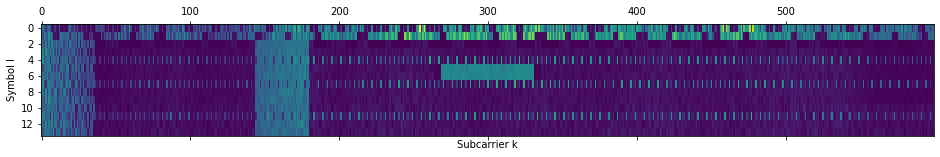

In [428]:
# make sure the current subframe 5 be of even numbered SFN
subf5_start = pbch_start + int(4.5*Fs/1000) + (sfn%2)*2*half_frame

s_subf5 = rxf[subf5_start : subf5_start + int(1*Fs/1000) - N_CP - N_CP_extra] 
# subf5_start is the starting position of the first symbol after CP.

s_subf5 = s_subf5 * np.exp(-2j * np.pi * f_d * np.arange(len(s_subf5)) / Fs) # dont forget this

subf5 = np.zeros((14, N_rb_dl*12), dtype=complex)

start = 0
for l in range(14):
    
    if l == 7:
        start += N_CP_extra
    
    subf5[l,:] = extract_OFDM(s_subf5[start:start+N_FFT],N_rb_dl)
    start += N_CP + N_FFT
    
plt.matshow(np.abs(subf5),aspect='auto')
plt.xlabel('Subcarrier k')
plt.ylabel('Symbol l')

plt.show()

The spectrogram shows the control region occupies the first one OFDM symbol. The first segments of resource blocks (near 3) are carried user data. The middle bright region is another duplicated PSS and SSS. 

### Channel estimation for the entire subframe 5 by CRS
Note, after decoding MIB, we know two antenna ports are activated. 

In [429]:
h_subf5 = np.zeros((2,4,N_rb_dl*12),dtype=complex)

for p in range(2):
    i = 0
    for l in [0,4,7,11]:
        if l < 7:
            ns = 10
        else:
            ns = 11
            
        k,crs = crs_in_re(p,l%7,ns,N_id,N_rb_dl)
        h_subf5[p][i][k] = subf5[l][k] * np.conj(crs)
        i += 1

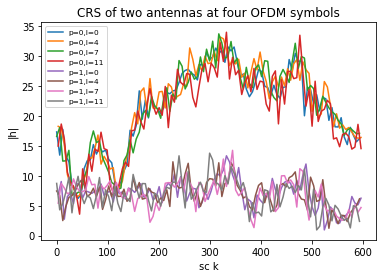

In [430]:
for p in range(2):
    i = 0
    for l in [0,4,7,11]:
        k,crs = crs_in_re(p,l%7,ns,N_id,N_rb_dl)
        plt.plot(k,np.abs(h_subf5[p][i][k]),label='p={:d},l={:d}'.format(p,l))
        i += 1
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.legend(fontsize=7.4)
plt.title('CRS of two antennas at four OFDM symbols')
plt.show()

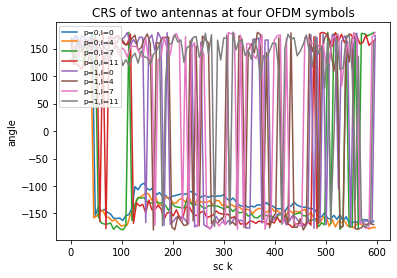

In [431]:
for p in range(2):
    i = 0
    for l in [0,4,7,11]:
        k,crs = crs_in_re(p,l%7,ns,N_id,N_rb_dl)
        plt.plot(k,np.angle(h_subf5[p][i][k])*180/np.pi,label='p={:d},l={:d}'.format(p,l))
        i += 1
    
plt.xlabel('sc k')
plt.ylabel('angle')
plt.legend(fontsize=7.4,loc='upper left')
plt.title('CRS of two antennas at four OFDM symbols')
plt.show()

In [432]:
# intepolate: frequency as before
for p in range(2):
    i = 0
    for l in [0,4,7,11]:
        if l < 7:
            ns = 10
        else:
            ns = 11
            
        k,crs = crs_in_re(p,l%7,ns,N_id,N_rb_dl)
        
        for kk in range(12*N_rb_dl):
            n = k[np.argmin(np.abs(k - kk))]
            h_subf5[p][i][kk] = h_subf5[p][i][n]
        
        i += 1    

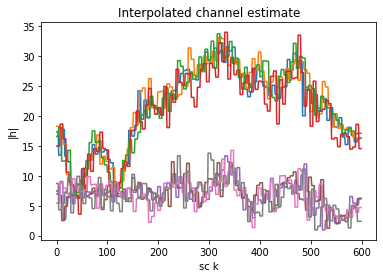

In [433]:
for p in range(2):
    for i in range(4):
        plt.plot(np.abs(h_subf5[p][i]))
    
plt.xlabel('sc k')
plt.ylabel('|h|')
plt.title('Interpolated channel estimate')
plt.show()

## Task 3: Decode the PCFICH

The PCFICH is always transmitted in the first symbol of every subframe. Its sole purpose is to signal how many of the symbols at the beginning of the subframe are allocated to the PDCCH. Permitted values to be conveyed by the Control Format Indicator (CFI) are 1, 2, or 3.

These three options are each encoded as 32 bit patterns specified in Table 5.3.4-1 of TS 36.212.

These encoded bits are then scrambled, QPSK modulated, space-time (Alamouti) coded, and mapped to resource elements in the first symbol.

Correspondingly, we must perform the following steps to extract the CFI:

1. Locate the samples in symbol 0 of subframe 5 of an even-numbered frame and perform frequency correction before OFDM demodulation
2. Use CRS symbols in symbol 0 to estimate the frequency response from each of the antennas to the receiver
3. Extract resource elements for PCFICH 
4. Perform transmit diversity (Alamouti) combining and equalization
5. Demodulate QPSK symbols
6. Descramble
7. Identify the best matching 32-bit pattern to determine the CFI

### Extract CFI Resource Elements

The location of resource elements holding CFI is specified in section 6.7.4 of TS 36.211:

The mapping to resource elements is defined in terms of quadruplets of complex-valued symbols. Let
$z^{(p)}(i)= \{y^{(p)}(4i),y^{(p)}(4i+1),y^{(p)}(4i+2),y^{(p)}(4i+3)\}$ denote symbol quadruplet $i$ for antenna port $p$.
For each of
the antenna ports, symbol quadruplets shall be mapped in increasing order of $i$ to the four resource-element groups in the first OFDM symbol in a downlink subframe or DwPTS with the representative resource-element as defined in clause 6.2.4 given by

\begin{align*}
z^{(p)}(0) \text{ is mapped to the resource-element group represented by } & k = \bar{k}\\
z^{(p)}(1) \text{ is mapped to the resource-element group represented by } & k = \bar{k} + \lfloor N_{RB}^{DL}/2 \rfloor \cdot N_{sc}^{RB}/2\\
z^{(p)}(2) \text{ is mapped to the resource-element group represented by } & k = \bar{k} + \lfloor 2N_{RB}^{DL}/2 \rfloor \cdot N_{sc}^{RB}/2\\
z^{(p)}(3) \text{ is mapped to the resource-element group represented by } & k = \bar{k} + \lfloor 3N_{RB}^{DL}/2 \rfloor \cdot N_{sc}^{RB}/2
\end{align*}

where the additions are modulo $N^{DL}_{RB} \cdot N^{RB}_{sc}$,
$$
\bar{k}=(N_{sc}^{RB}/2)\cdot(N_{ID}^{cell} \mod 2 N_{RB}^{DL})
$$
and $N_{ID}^{cell}$ is the physical-layer cell identity as given by clause 6.11.

The specification references *Resource Element Groups* (REG); these are defined in section 6.2.4 of TS 36.211. In short, A REG comprises four resource elements that are not used for CRS. In other words,
* for OFDM symbols that do not include CRS (e.g., symbol 2), a REG consists of 4 consecutive resource elements; each resource block holds 3 REGs.
* for OFDM symbols that do include CRS (e.g., symbol 0), a CREG is contained in a group of six consecutive REs and the REG excludes the locations of CRS elements; each resource block can hold 2 REGs.

To determine the location of CRS elements, we use the number of antennas in the system; except, for systems with a single antenna, CRS locations are determined as if there were two antennas.

Since the PCFICH is always located in symbol $l=0$, we will have CRS elements on every third RE starting at a value that depends on the cell id and the slot number. The starting value is the smallest index $k$ for the location of CRS computed by function `crs_syms_and_k`.

The function below computes the subcarrier indices that hold PCFICH information symbols.

In [434]:
def PCFICH_locs(N_RB, N_id):
    """Compute subcarrier indices for PCFICH
    
    Inputs:
    N_RB - number of subcarriers 
    N_id - cell id

    Returns:
    length-16 vector of subcarrier indices
    """
    k_ind = np.zeros(16, dtype=int)

    N_SC_RB = 12
    N_SC_RB_2 = N_SC_RB // 2

    k_bar = N_SC_RB_2 * (N_id % (2 * N_RB))

    m = 0
    for n in range(4):
        # loop over quadruplets
        k_init = k_bar + ((n*N_RB) // 2) * N_SC_RB_2

        for i in range(6):
            if (i % 3) != 0:  # skip CRS
                k_ind[m] = (k_init + i) % (N_RB * N_SC_RB)
                m += 1

    return k_ind

In [435]:
# extract the first OFDM symbol.
s_sym0 = s_subf5[:N_FFT]

# convert to frequency domain (entire bandwidth)
sym0 = extract_OFDM(s_sym0, N_rb_dl) 

h_sym0 = h_subf5[:,0,:]

### Transmit Diversity (Alamouti) Combining

In [436]:
s_sym0 = s_subf5[:N_FFT] # frequency offset has been corrected

# convert to frequency domain (entire bandwidth)
sym0 = extract_OFDM(s_sym0, N_rb_dl) 

h_sym0 = h_subf5[:,0,:]

In [437]:
cfi_k = PCFICH_locs(N_rb_dl, N_id)

r_pcfich = sym0[cfi_k]
h0_pcfich = h_sym0[0][cfi_k]
h1_pcfich = h_sym0[1][cfi_k]

cfi_k

array([145, 146, 148, 149, 295, 296, 298, 299, 445, 446, 448, 449, 595,
       596, 598, 599])

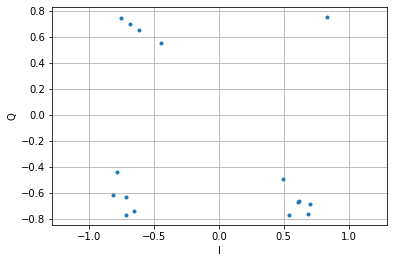

In [438]:
x_pcfich = Alamouti_combine(r_pcfich,h0_pcfich,h1_pcfich)

plt.plot(x_pcfich.real,x_pcfich.imag,'.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

### QPSK Demodulation


In [439]:
pcfich_scrambled_bits = qpsk_demodulate(x_pcfich)

pcfich_scrambled_bits.size

32

### Descrambling

Scrambling for the PCFICH is defined in section 6.7.1 of TS 36.211.

The PCFICH scrambler uses the same pseudo-random number generator $c(n)$ as the PBCH (MIB). However, the initialization is given by:
$$
    c_{init} = (\lfloor n_s/2\rfloor + 1) \cdot (2 N_{ID}^{cell}+1) \cdot 2^9 + N_{ID}^{cell},
$$


In [440]:
n_s = 10
c_init = (((n_s // 2 + 1) * (2 * N_id + 1)) << 9) + N_id

c = c_sequence(len(pcfich_scrambled_bits),c_init)

pcfich_bits = pcfich_scrambled_bits ^ c

### CFI Decoding

The final step in CFI processing is to determine the CFI value from the 32 PCFI bits.

Section 5.3.4.1 in TS 36.212 provides a 32 bit pattern for each of the three possible CFI values (1, 2, 3). 

In [441]:
## CFI decoding
# table of bit sequences for each CFI value (Table 5.3.4-1 in TS 36.212)
CFI_code_table = {
    1: np.array([0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1], dtype=np.uint8),
    2: np.array([1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0], dtype=np.uint8),
    3: np.array([1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1], dtype=np.uint8),
}

# compute distances
dist = np.zeros(3)
CFI_vec = np.zeros(3, dtype=int)

n = 0
for CFI_vec[n], cfi_seq in CFI_code_table.items():
    dist[n] = hamming_dist(pcfich_bits, cfi_seq)
    n += 1

obs_CFI = CFI_vec[np.argmin(dist)]

# When BW is low, CFI is one longer than indicated on PCFICH (see Table 6.7-1 in TS 36.211)
if N_rb_dl <= 10:
    CFI = obs_CFI + 1
else:
    CFI = obs_CFI

print('CFI = {:d}. Decoded CFI: hard: {:d} Hamming distance: {:1.0f}'.format(
    CFI, obs_CFI, np.min(dist))
)

CFI = 2. Decoded CFI: hard: 2 Hamming distance: 0


### Where are we now and what's next?

This completes our processing of the Physical Control Format Indicator Channel. We have successfully determined the subframe that contains SIB1 uses `CFI = 1`. 

That means that in this subframe only one symbol (the first, i.e., symbol 0) is allocated to carry the Physical Downlink Control Channels (PDCCH).

We must process the PDCCH next. The goal is to find the *Downlink Control Indicator* (DCI) that points us to where we find the SIB1 in the remaining symbols of subframe 5.

After that, we can locate and decode SIB1 itself.

## Task 4: Decode the PDCCH

The CFI told us that only one OFDM symbol in subframe 5, symbol 0, is allocated to carry the PDCCH. 

The problem is that symbol 0 also carries CRS, the PCFICH, and the PHICH (Physical Hybrid ARQ Channel). The PDCCH can use all resource elements that aren't allocated to one of these three purposes.

We're familiar with the first two. For our purposes, we do not care about the contents of the PHICH. However, we must determine which REs are occupied by the PHICH. We must figure that out first.

#### Detour: Where is the PHICH?

We only need to know where the PHICH Resource elements are located; their contents is of no interest to us. Section 6.9 of TS 36.211 escribes the PHICH.

It is easiest to describe the PHICH location in terms of REGs. Recall that REGs contain four non-CRS resource elements. And, since symbol 0 does contain CRS, each PRB contains two REGs. There is a total of 100 REGs when the bandwidth consists of $N_{RB}^{DL}$ resource blocks. We saw that four of these are occupied by the PCFICH. This leaves 96 REGs.

According to section 6.9 of TS 36.211, the number of REGs occupied by the PHICH depends on a quantity called the PHICH groups $N_{PHICH}^{group}$. This quantity depends on information provided by the MIB, specifically, the number of downlink resource blocks $N_{RB}^{DL}$ and the PHICH parameter `phich-Resource` (which was decoded as `one`). For the normal cyclic prefix
$$
N_{PHICH}^{group} = \lceil N_g \cdot (N_{RB}^{DL}/8) \rceil,
$$
where $N_g \in \{1/6, 1/2, 1, 2\}$ is selected by `phich-Resource`.

For our parameters, $N_{PHICH}^{group} = \lceil 1 \cdot 50/8) \rceil = 7$. Section 6.9.3 implies that $7 \cdot 3 = 21$ REGs will be allocated to the PHICH.

To determine the REGs that are assigned to the PHICH, section 6.9.3 specifies an algorithm that causes REGs in three evenly spaced clusters of REGs - each of size $N_{PHICH}^{group}$ - to be allocated. In the allocation, REGs allocated to the PCFICH are skipped.

All PHICH resource elements go in the first symbol since the the control section of the subframe is only one symbol long and because `phich-Duration` was indicated as `normal`. When this is not true, some PHICH symbols can go in the second symbol as well. (see section 6.9.3)

Below, we compute the sets of REGs occupied by the PCFICH and the PHICH and determine which REGs are left for the PDCCH.

In [442]:
# start will all REGs
all_REG = {n for n in range(2*N_rb_dl)}

# PCFICH REGs are fairly easy 
PCFI_REG = {(N_id % (2*N_rb_dl) + ((n*N_rb_dl) // 2) % (2*N_rb_dl)) for n in range(4)}

# this is what's left for PHICH and PDCCH
all_REG.difference_update(PCFI_REG)
all_REG_vec = np.sort(np.array([n for n in all_REG]))
n_0 = len(all_REG)

# now deal with the PHICH
PHICH_REG = set()

# note: this is specific to FDD and normal CP
Ng = 1   # this reflects phich-Resource from MIB
N_group = (Ng * N_rb_dl) // 8
if 8*N_group < Ng * N_rb_dl:
    N_group += 1

for m in range(N_group):
    for i in range(3):
        n_i = (N_id + m + ((i*n_0) // 3)) % n_0 # index into all_REG_vec
        reg = all_REG_vec[n_i]   # the actual REG
        
        # move REG from all_REG to PHICH_REG
        all_REG.discard(reg)
        PHICH_REG.add(reg)
        
print("After PCFICH and PHICH, there are {:d} REGs left for the PDCCH at the first OFDM symbol".format(len(all_REG)))

After PCFICH and PHICH, there are 75 REGs left for the PDCCH at the first OFDM symbol


### What is Control Channel Elements (CCE)

The information in the Control Region of the frame, is organized into a number of PDCCH channels arccording to the following principles set forth in section 6.8.1 of TS 36.211:

The physical downlink control channel carries scheduling assignments and other control information. A physical control channel is transmitted on an aggregation of one or several consecutive control channel elements (CCEs), where a control channel element corresponds to 9 resource element groups. The number of resource-element groups not assigned to PCFICH or PHICH is $N_{REG}$. The CCEs available in the system are numbered from $0$ to $N_{CCE} −1$, where
$N_{CCE} = \lfloor N_{REG} / 9 \rfloor$. The PDCCH supports multiple formats as listed in Table 6.8.1-1. A PDCCH consisting of $n$
consecutive CCEs may only start on a CCE fulfilling $i \mod n = 0$ , where $i$ is the CCE number. 

Multiple PDCCHs can be transmitted in a subframe. 

![PDCCH Formats](pdcch_format.png)

## How is the PDCCH constructed from the DCI

According to TS 36.212 section 5.3.3.1, DCIs have multiple formats that indicates to different type of transmitted user data. Unlike MIB, the length of DCI is not fixed. For our work, we only need to care about DCI format 1A since it corresponds to the system information SIB1. Furthermore, the DCI format 1A that points to the system information always occupies the first 8 CCEs.

The steps of construction and transmission of DCIs are similar to MIB as shown in the figure below:

![PDCCH process](pdcch_process.png)

Some steps that should be emphasized are:

1. **CRC** a 16-bit CRC is appended and scrambled with the corresponding RNTI (TS 36.212 sections 5.3.3.2), e.g., in terms of SIB1, the corresponding RNTI is SI-RNTI with value 0xFFFF (TS 36.321 sections 7.1)
2. **Rate Matching** The length of each DCI bits after rate matching depends on the length of used CCEs, respectively. 
3. **Scrambling** The length of scrambled bits is two times the total available REs (because of QPSK) belonging to PDCCH. Note, the available REs may not be a multiple of a CCE. The very last bits will be useless bits for complementing the length of PDCCH (TS 36.211, section 6.8.2).
4. **Mapping to Resource Elements** According to TS 36.211, section 6.8.5, the mapping is based on quadruplets of complex-valued symbols. Let
$z^{(p)}(i)= \{y^{(p)}(4i),y^{(p)}(4i+1),y^{(p)}(4i+2),y^{(p)}(4i+3)\}$ denote symbol quadruplet $i$ for antenna port $p$. The blocks of quadruplets will first be permuted according to the previous sub-block interleaver in rate matching in terms of symbol quadruplets. The blocks of quadruplets will then be cyclically shifted by PCI. Lastly, the mapping of the block of quadruplets is defined in REGs, based on the metric of indexing REGs (TS 36.211 section 6.2.4). 

The figure below shows how REGs are indexed:
![REG](reg.png)

The numbering of the REGs within the control region depends on the lowest frequency-
domain indexing of the REs in the group, and it follows the time priority. For example, in
the case of two antenna ports shown in Figure 3.11, the REG with index 0 is the first one in
the first OFDM symbol, where the lowest frequency-domain index of the RE is 0 at symbol
0. The REG with index 1 is the first one in the second OFDM symbol, and the REG with
index 3 is the second REG in the second OFDM symbol, where the lowest index of the RE
is 4 at symbol 1, and so on.

The function below computes the right order of REG indices for mapping symbols to RE: 

In [443]:
def PDCCH_locs(pdcch_available_reg_l1,N_rb_dl,CFI,col_perm_table):
    """Compute REG indices for PDCCH"""

    # Extract REGs in resource grid
    pdcch_reg_l1 = [(0,6*i) for i in list(pdcch_available_reg_l1)]
    pdcch_reg_l2 = [(1,4*i) for i in np.arange(N_rb_dl*3)] # for two antennas
    pdcch_reg_l3 = [(2,4*i) for i in np.arange(N_rb_dl*3)]

    pdcch_reg = []

    if CFI == 1:
        pdcch_reg = pdcch_reg_l1
    elif CFI >= 2:
        if CFI == 2:
            all_reg = pdcch_reg_l1 + pdcch_reg_l2   
        elif CFI == 3:
            all_reg = pdcch_reg_l1 + pdcch_reg_l2 + pdcch_reg_l3    

        for k in range(N_rb_dl*12):
            l = 0
            while l < CFI:
                if (l,k) in all_reg:
                    if l == 0:
                        pdcch_reg.append((l,k))
                    elif l > 0:
                        pdcch_reg.append((l,k))
                l += 1
                
    pdcch_reg = np.array(pdcch_reg)
    N_reg = len(pdcch_reg)

    # de-cyclic shift
    pdcch_reg_cs = np.roll(pdcch_reg,(N_id%N_reg),axis=0)

    # de-interleaving
    ind  = np.arange(N_reg)                   
    perm_table = subblock_interleaver(ind,col_perm_table)

    pdcch_num_reg = np.zeros_like(pdcch_reg)
    pdcch_num_reg[perm_table] = pdcch_reg_cs

    # return a number of (l,k) pairs denoting the index of REGs.
    return pdcch_num_reg

In [444]:
pdcch_num_reg = PDCCH_locs(all_REG,N_rb_dl,CFI,col_perm_table)

pdcch_num_reg[:10]

array([[  1,  12],
       [  1,  40],
       [  1, 340],
       [  0, 186],
       [  1, 492],
       [  1, 116],
       [  0, 408],
       [  0, 270],
       [  1, 560],
       [  0,  84]])

### Channel estimation for PDCCH by CRS

In [445]:
pdcch = []
h_pdcch = []

for (l,k) in pdcch_num_reg:
    if l == 0:
        ind = [1,2,4,5]
    else:
        ind = np.arange(4)
    
    for m in ind:
        pdcch.append(subf5[l][k+m])
        for p in range(2):
            h_pdcch.append(h_subf5[p][0][k+m])

### Transmit Diversity (Alamouti) Combining

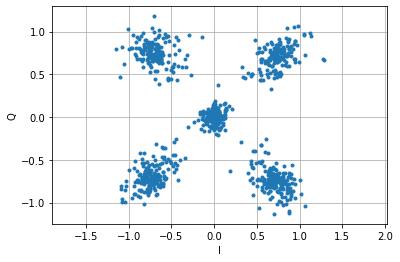

In [446]:
x_pdcch = Alamouti_combine(np.array(pdcch),np.array(h_pdcch[0::2]),np.array(h_pdcch[1::2]))

plt.plot(x_pdcch.real,x_pdcch.imag,'.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

### QPSK Demodulation

In [447]:
pdcch_scrambled_bits = qpsk_demodulate(x_pdcch)

### Descrambling

In [448]:
ns = 10
c_init = ((ns // 2) << 9) + N_id

c = c_sequence(len(pdcch_scrambled_bits), c_init)

pdcch_bits = pdcch_scrambled_bits ^ c

### Rate Matching
As we discussed, the size of DCI before rate matching is varying. Furthermore, it happens more than one PDCCH are aggregated in one subframe. In the figure below, it shows two PDCCH are aggregated in this subframe.

Fortunately, for our task, we only focus on decoding the system information SIB1, which always occurs at the first 8 CCEs. We can apply a simple correlation to determine the size of SIB1 by determining the length of the repeated block.

<!-- In this notebook, we also give an example of decoding the rest PDCCH and the corresponding user data in the PDSCH. This requires a process of blind search in real-time processing, which trys different lengths and positions of PDCCH by CRC. 
Here, we bypass this progress by directly knowing the position of PDCCH through the figure.  -->

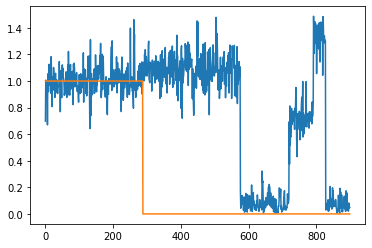

In [449]:
win = np.zeros_like(x_pdcch)
CCE = 36

plt.plot(np.abs(x_pdcch))

win[:8*36] = 1
plt.plot(np.abs(win))

plt.show()

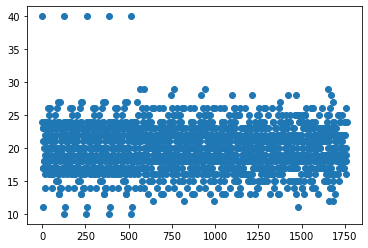

The distance between repeated DCI: [0, 129, 258, 387, 516]


In [450]:
wl = 40 # observation window length
pdcch_f = pdcch_bits[:wl]
corr = []

win = 0
while win <= len(pdcch_bits)-wl:
    corr.append(wl-np.sum(pdcch_f ^ pdcch_bits[win:win+wl])) 
    win += 1
    
plt.plot(corr,'o')
plt.show()

print('The distance between repeated DCI: {:}'.format([i for i, x in enumerate(corr) if x == 40]))

#### Extract the DCI bits before bit collection and pruning

In [451]:
l_dci_3x = 129

l_dci = l_dci_3x//3

dci_bits = pdcch_bits[:l_dci_3x]

#### Subblock Interleaver

In [452]:
ind  = np.arange(l_dci)                   
perm_table = subblock_interleaver(ind,col_perm_table) 

dci_coded_bits = np.zeros((3,l_dci),dtype=np.uint8)

for n in range(3):
    dci_coded_bits[n,perm_table] = dci_bits[n*l_dci:(n+1)*l_dci] 

#### FEC

In [453]:
fec = ConvCoder([0o133, 0o171, 0o165])
dci_hard_bits, cost = fec.decode(dci_coded_bits,hamming_dist)

print("cost = {:f}, bits = {:}".format(cost, dci_hard_bits))

cost = 0.000000, bits = [1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0
 1 0 0 0 0 0]


#### CRC: 
One thing should be noted: the 16 parity bits are scrambled by RNTI.

The value of RNTI can be checked in TS 36.321 7.1.

In [454]:
n_dci = l_dci-16

dci_bits = dci_hard_bits[:n_dci]

crc_match = False

for rnti in range(0xFFFF+1):
    parity_bits = dci_hard_bits[n_dci:] ^ [int(b) for b in bin(rnti)[2:].zfill(16)]

    pdcch_crc_bits = np.concatenate([dci_bits,parity_bits])

    bytes = np.packbits(pdcch_crc_bits)

    if crc(bytes) == 0:
        crc_match = True
        break
    
    
if crc_match:
    print('Found DCI: {:}. The scrambled RNTI is {:}'.format(
                                            dci_bits,hex(rnti)))
else:
    print('no valid DCI found.')

Found DCI: [1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0]. The scrambled RNTI is 0xffff


The scrambled RNTI is 0xFFFF, according to TS 36.321 7.1, it corresponds to SI-RNTI, i.e., indicates the SIB1.

#### Decode the DCI
The 27-bit DCI shows:
- 1: format 1A
- 0: localized VRB
- [0 0 0 0 1 1 0 0 1 0 0]: resource indication value (RIV) is 100
    - According to TS 36.213, section 7.1.6.3, $RB_{start}=0$, $L_{CRBs}=3$.
- [0 0 1 1 0]: modulation and coding scheme ($I_{MCS}$) is 6
    - According to TS 36.213, section 7.1.7, $Q_m = 2$ (modulation order), $I_{TBS} = 6 = I_{MCS}$, $N_{PRB}^{1A} = 2$, $TBS = 176$ (transport block size) 
- [0 0 0]: HARQ process number
- 0: new data indicator
- [1 0]: redundency version is 2
- [0 0]: TPC command for PUCCH. The LSB determines $N_{PRB}^{1A} = 2$.
- 0: N-Gap 1



## Task 5: Decode the SIB1

### Extract the SIB1 Symbols and Its Channel Estimate
As indicated by the decoded DCI (scrambled by SI-RNTI), `the SIB1 is located at the first (0th) resource block and lasts for 3 resource blocks` (also shown in the spectrogram of subframe 5 above). Furthermore, other useful information from decoded DCI includes 
- the transport block size before CRC (176 bits)
- the redundency version (2)
- the modulation order (2, indicating QPSK)
- localized VRB.

We should also notify the size of control region, i.e., the rest OFDM symbols in the subframe 5 belongs to the traffic region (PDSCH). Now we first collect the symbols for SIB1 together with the channel estimates by CRS.

In [455]:
# SIB1 information from decoded DCI
rb_pdsch_start = 0
N_rb_pdsch = 3
TBS = 176
rv = 2

In [456]:
tmp0 = np.zeros((14,12*N_rb_dl),complex)
tmp1 = np.zeros((14,12*N_rb_dl),complex)

# define mask for positions of CRS
ex_index = np.arange(0,N_rb_pdsch*12,3)
mask = np.ones(N_rb_pdsch*12,dtype=bool)
mask[ex_index] = False

r_pdsch = np.array([], dtype=complex)
h0_pdsch = np.array([], dtype=complex)
h1_pdsch = np.array([], dtype=complex) 

for l in range(14):
    # intepolate in time domain for entire PDSCH. In one slot,
    # CRS at symbol 0 for symbols 0 to 3, 4 for symbols 4 to 6.
    if l < 4:
        tmp0[l,:] = h_subf5[0][0]
        tmp1[l,:] = h_subf5[1][0]
    elif l < 7:
        tmp0[l,:] = h_subf5[0][1]
        tmp1[l,:] = h_subf5[1][1]
    elif l < 11:
        tmp0[l,:] = h_subf5[0][2]
        tmp1[l,:] = h_subf5[1][2]
    else:
        tmp0[l,:] = h_subf5[0][3]
        tmp1[l,:] = h_subf5[1][3]
        
    # extract resource elements for sib1 (excluding CRS)   
    if l >= CFI:
        tmp = subf5[l][rb_pdsch_start*12:(rb_pdsch_start+N_rb_pdsch)*12]
        h_tmp0 = tmp0[l][rb_pdsch_start*12:(rb_pdsch_start+N_rb_pdsch)*12]
        h_tmp1 = tmp1[l][rb_pdsch_start*12:(rb_pdsch_start+N_rb_pdsch)*12]
        
        # exclude crs
        if l in [0,4,7,11]:
            r_pdsch = np.concatenate((r_pdsch,tmp[mask]))
            h0_pdsch = np.concatenate((h0_pdsch,h_tmp0[mask]))
            h1_pdsch = np.concatenate((h1_pdsch,h_tmp1[mask]))

        else:
            r_pdsch = np.concatenate((r_pdsch,tmp))
            h0_pdsch = np.concatenate((h0_pdsch,h_tmp0))
            h1_pdsch = np.concatenate((h1_pdsch,h_tmp1))

## How is the SIB1 constructed in PDSCH

According to the decoded DCI, the SIB1 carries 176 bits of information. These bits are processed as follows:
1. **CRC** a 24-bit CRC is appended; that expands the number of bits to 200 (TS 36.212, section 5.3.2.1 and 5.1.1)
2. **Code Block Segmentation and Code Block CRC Attachment (not for our case)** 
According to TS 36.212, section 5.3.2.2 and 5.1.2, the transport block after CRC will be segmented (maximum 2 segments) and attached an additional 24-bit CRC sequence each if it exceeds the maximum code block size $Z=6144$. Moreover, the filler bits will be added at the beginning of the first block if there is code segmentation.
3. **FEC** a rate 1/3 turbo code is applied to produce $(200+4)\cdot 3=612$ coded bits (TS 36.212, section 5.1.3.2). The extra 12 bits come from trellis termination that are used for resetting the states in turbo coder.
4. **Rate Matching** the coded bits are permuted, interleaved and repeated to yield the size (converting to bits needs to be multiply by 2) of extracted resources that is indicated by DCI.
5. **Code Block Concatenation (not for our case)** According to TS 36.212, section 5.1.5, the code block concatenation consists of sequentially concatenating the rate matching outputs for the different code blocks. 
6. **Scrambling** similar to PBCH but scrambled by 612 bits.
7. **Modulation** according to TS 36.211, section 6.3.2, PDSCH supports QPSK, 16QAM, 64QAM and 256QAM. The exact modulation type of carried user data in PDSCH is indicated by DCI (in our case, it's QPSK).
8. **Layer Mapping and Precoding** same to PBCH.

### Layer Mapping and Precoding:

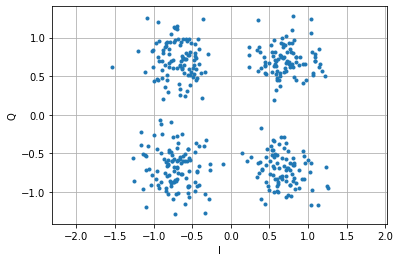

In [457]:
x_pdsch = Alamouti_combine(r_pdsch,h0_pdsch,h1_pdsch)

plt.plot(x_pdsch.real,x_pdsch.imag,'.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

### QPSK demodulation

In [458]:
pdsch_scrambled_bits = qpsk_demodulate(x_pdsch)

### Soft Scrambling
The reason of using soft scrambling instead of hard scrambling as before is due to the algorithm applied for turbo decoder in this notebook supports soft input soft output (SISO).

In [459]:
ns = 10
q = 0 # the number of codewords. 0 or 1.
c_init = (rnti << 14) + (q << 13) + ((ns // 2) << 9) + N_id

c = c_sequence(len(pdsch_scrambled_bits),c_init)

pdsch_bits = pdsch_scrambled_bits * (1.-2*c)

### Rate Matching:
The structure of rate matching for turbo coded transport channels is similar to the one for convolutional coder. The figure of structure is given again as below:

![Rate Matching](rate_matching.png)

In particular, the differences are:
- According to TS 36.212 section 5.1.4.1.1, the first two subblock interleavers perform the same permutation as for the convolutional coder. The third subblock interleaver performs the permutation following the rule: the output $v_k = y_{\pi(k)}$, where $$
\pi(k) = \bigg(P(\lfloor\frac{k}{R}\rfloor)+C\times(k\mod R)+1\bigg) $$ 
and where $P(\cdot)$ is the permutation function defined in TS 36.212 table 5.1.4-1, $C=32$ and R is computed in the previous steps of subblock interleaver.
- According to TS 36.212 5.1.4.1.2, bit collection is proceeded by first collecting the entire bits from the first subblock interleaver, and interleavedly from the second and third subblock interleaver. The bit selection is performed following the same rule as for convolutional coder but starting from the index $k_0$ that is computed by $$ k_0 = R\cdot \bigg(2\cdot\lceil \frac{N_{cb}}{8R}\rceil\cdot rv+2\bigg) $$
where $rv$ denotes the redundancy version that is indicated in DCI, $N_{cb}$ is normally equal to the total length of circular buffer.

The function below computes the mapping of indices of bits through rate matching: 

In [460]:
def rate_matching_turbo(seq,col_perm_table,rv):
    
    C = 32
    D = len(seq)
    
    DUMMY = D+10000

    R = D // C
    if R * C < D:
        R = R + 1
        
    K_pi = R*C
            
    N_dummy = K_pi - D
    y = np.concatenate( (DUMMY *np.ones(N_dummy, dtype=seq.dtype), seq) )
    M = np.reshape(y, (R, C))
    
    # port 1 and 2
    p = np.zeros_like(M)
    for n in range(C):
        p[:,n] = M[:,col_perm_table[n]]
        
    v = np.reshape(p.T, -1)
        
    # port 3
    k = np.arange(K_pi)
    pi_k = (col_perm_table[k//R] + C*(k%R) + 1) % K_pi
    
    v3 = y[pi_k]
        
    # distinguish between three blocks
    v1 = v.copy()
    v2 = v.copy()
    v2[v2 < DUMMY] += D
    v3[v3 < DUMMY] += 2*D
        
    # collection
    N_cb = 3*K_pi    
    v_comb = np.zeros(N_cb,int)
    v_comb[:K_pi] = v1
    v_comb[K_pi::2] = v2
    v_comb[K_pi+1::2] = v3
        
    # selection and pruning
    k0 = int(R*(2*np.ceil(N_cb/(8*R))*rv + 2))
    
    k = 0
    j = 0
    e = np.zeros(3*D,int)
    while k < 3*D:
        if v_comb[(k0+j)%N_cb] != DUMMY:
            e[k] = v_comb[(k0+j)%N_cb]
            k += 1
        j += 1
        
    return e

In [461]:
CRC_len = 24
trellis_end = 4
coded_block_size = TBS + CRC_len + trellis_end
collect_len = 3*coded_block_size

ind = np.arange(coded_block_size)
col_perm_table = np.array([0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30,
                           1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31])

perm_table = rate_matching_turbo(ind,col_perm_table,rv)

pdsch_coded_bits = np.zeros(collect_len)
pdsch_coded_bits[perm_table] = pdsch_bits[:collect_len]
pdsch_coded_bits = pdsch_coded_bits.reshape(3,coded_block_size)

### FEC Decoding

Forward error correction (FEC) coding for the PDSCH is performed according to TS 36.212, section 5.1.3.2. The operation of the coder is summarized in Figure 5.1.3-2 which is replicated below.

![Figure 5.1.3-2: Rate 1/3 turbo encoder](turbo_coder.png)

This is a rate 1/3 turbo code with trellis termination; 
4 extra bits will be added due to trellis termination
that are used for resetting the states in turbo coder.

### BCJR Decoding

The turbo coder used in LTE is also denoted as parallel concatenated coder. For turbo decoder, iterative decoding 
is performed between two decoders, each runnng the logarithmic BCJR algorithm.

The logarithmic BCJR algorithm performs as soft-in, soft-out decoding, which inputs and outputs the log likelihood ratio (LLR) of each bit in the codeword by maximum a posterioiri.

The major part of the computation of logarithmic BCJR is in running two Viterbi-like algorithms, one forward and one backward, through the trellis.
- the forward recursion is also called $\alpha$ calculation, which in particular computes the probabilities of being in a particular state at time t given the received symbols from the start up to t. It captures how likely it is that the encoder was in a specific state given the past inputs and received signals (like Viterbi in convolutional decoder).
- the backward recursion is denoted as $\beta$ calculation, which computes the probabilities of ending up in a state at time t given the future received symbols. This captures the likelihood of future states contributing to the current state.
- branch metric calculation, also denoted as $\gamma$ calculation, which represents the probability of transitioning between states based on the received symbols at time t. It evaluates how likely a state transition occurred given the observed signal.

The figure below shows the structure of turbo decoder:
![Rate 1/3 turbo decoder](turbo_decoder.png)

The operations in each decoder are performed as follows:
- Receive extrinsic information from the other decoder regarding the LLRs of information bits (starts at 0). Use these as $L_{in}(u)$ for logarithmic BCJR algorithm. Operate with channel outputs in each decoder. 
- Run forward and backward recursions in logarithmic BCJR algorithm.
- Compute $L_{code}(u)$ for each information bit $u$. Feed back as extrinsic information to the other decoder.

The functions below implement the logarithmic BCJR decoding algorithm:

In [462]:
# A brunch of helper functions
def bits_to_LLRs(bits, noise_sigma):
    """Transfer soft bits to LLR under QPSK and AWGN"""
    return -2 * bits / noise_sigma**2

def turbo_len(transport_size):
    pdsch_crc_len = 24
    turbo_tail = 4
    return transport_size + pdsch_crc_len + turbo_tail

def turbo_permutation(K, f1, f2):
    i = np.arange(K)
    return (f1 * i + f2 * i**2) % K

def turbo_permutation_inv(K, f1, f2):
    fwd = list(turbo_permutation(K, f1, f2))
    return np.array([fwd.index(i) for i in range(K)])

In [463]:
# Main functions
def maxstar(a, b):
    result = np.empty_like(a)
    ainf = a == -np.inf
    binf = b == -np.inf
    result[ainf] = b[ainf]
    result[binf] = a[binf]
    noninf = (a != -np.inf) & (b != -np.inf)
    an = a[noninf]
    bn = b[noninf]
    result[noninf] = np.maximum(an, bn) + np.log1p(np.exp(-np.abs(an-bn)))
    return result

def BCJR(Ru, R, Ap):
    T = Ru.size # time steps
    nu = 3 # number of states = 2^nu
    Gamma = np.empty((T, 2**nu, 2**nu))
    Gamma[...] = -np.inf
    A = np.empty((T, 2**nu))
    A[...] = -np.inf
    A[0, 0] = 0
    B = np.empty((T, 2**nu))
    B[...] = -np.inf
    B[-1, 0] = 0
    
    # States are encoded as the concatenation of the
    # bits in the shift register, with the oldest bit
    # in the LSB, so that the shift register is shifted
    # left in each epoch.
    for r in range(2**nu):
        for s in range(2**nu):
            # non-termination trellis
            if r >> 1 == s & (2**(nu-1)-1):
                # S_r to S_s is a trellis edge
                Gamma[:-nu, r, s] = 0
                feedback = (r ^ (r >> 1)) & 1
                # The information bit corresponding to the
                # transition from S_r to S_s
                newbit = (s >> (nu - 1)) ^ feedback
                if newbit == 0:
                    Gamma[:-nu, r, s] += Ap - np.log1p(np.exp(Ap))
                else:
                    Gamma[:-nu, r, s] += -Ap - np.log1p(np.exp(-Ap))
                c0 = newbit
                c1 = (r ^ (r >> 2) ^ (s >> (nu - 1))) & 1                
                if c0 == 0:
                    Gamma[:-nu, r, s] += Ru[:-nu] - np.log1p(np.exp(Ru[:-nu]))
                else:
                    Gamma[:-nu, r, s] += -Ru[:-nu] - np.log1p(np.exp(-Ru[:-nu]))
                if c1 == 0:
                    Gamma[:-nu, r, s] += R[:-nu] - np.log1p(np.exp(R[:-nu]))
                else:
                    Gamma[:-nu, r, s] += -R[:-nu] - np.log1p(np.exp(-R[:-nu]))
            # termination trellis
            if r >> 1 == s:
                # S_r to S_s is a trellis edge
                Gamma[-nu:, r, s] = 0
                feedback = (r ^ (r >> 1)) & 1
                c0 = feedback
                c1 = (r ^ (r >> 2)) & 1
                if c0 == 0:
                    Gamma[-nu:, r, s] += Ru[-nu:] - np.log1p(np.exp(Ru[-nu:]))
                else:
                    Gamma[-nu:, r, s] += -Ru[-nu:] - np.log1p(np.exp(-Ru[-nu:]))
                if c1 == 0:
                    Gamma[-nu:, r, s] += R[-nu:] - np.log1p(np.exp(R[-nu:]))
                else:
                    Gamma[-nu:, r, s] += -R[-nu:] - np.log1p(np.exp(-R[-nu:]))

    # Note: For A, t is numbered from 0 to T-1,
    # while for Gamma and B, it is numbered from 1 to T
    for t in range(1, T):
        for r in range(2**nu):
            A[t, :] = maxstar(A[t, :], A[t-1, r] + Gamma[t-1, r, :])

    for t in range(T-2, -1, -1):
        for s in range(2**nu):
            B[t, :] = maxstar(B[t, :], B[t+1, s] + Gamma[t+1, :, s])
    
    M = A[:, :, np.newaxis] + Gamma + B[:, np.newaxis, :]

    Lp = np.empty_like(Ap)
    Lm = np.empty_like(Ap)
    Lp[:] = -np.inf
    Lm[:] = -np.inf
    for r in range(2**nu):
        for s in range(2**nu):
            # always non-termination trellis
            if r >> 1 == s & (2**(nu-1)-1):
                feedback = (r ^ (r >> 1)) & 1
                newbit = (s >> (nu - 1)) ^ feedback
                if newbit == 1:
                    Lp = maxstar(Lp, M[:-nu, r, s])
                else:
                    Lm = maxstar(Lm, M[:-nu, r, s])
    return Lm - Lp

def turbo_decoder(Ru1, R1, Ru2, R2, f1, f2, num_iterations=50, maxA=512, maxR=512, do_plots=False):
    for R in [Ru1, R1, Ru2, R2]:
        R[:] = np.clip(R, -maxR, maxR)
    K = Ru1.size - 3
    E2 = np.zeros(K)
    for iteration in range(num_iterations):
        A1 = E2[turbo_permutation_inv(K,f1,f2)]
        A1 = np.clip(A1, -maxA, maxA)
        L1 = BCJR(Ru1, R1, A1)
        E1 = L1 - Ru1[:-3] - A1        
        A2 = E1[turbo_permutation(K,f1,f2)]
        A2 = np.clip(A2, -maxA, maxA)
        L2 = BCJR(Ru2, R2, A2)
        E2 = L2 - Ru2[:-3] - A2
        if do_plots:
            fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
            axs[0].plot(L1, '.')
            axs[1].plot(L2, '.', color='C1')
            axs[0].set_ylabel('L1')
            axs[1].set_ylabel('L2')
            fig.suptitle(f'LTE Turbo decoder iteration {iteration}', y=0.93)
            axs[1].set_xlabel('Message bit')
            plt.subplots_adjust(hspace=0)
    return L2[turbo_permutation_inv(K,f1,f2)]

def LTE_turbo_decoder(LLRs, transport_size, f1, f2, plot_channel_LLRs=False, **kwargs):
  
    if plot_channel_LLRs:
        plt.figure()
        plt.plot(LLRs.ravel(), '.')
        plt.title('LTE Turbo decoder channel LLRs')
    # Section 5.1.3.2.2 in TS 36.212 for trellis termination "shuffling"
    K = turbo_len(transport_size) - 4
    # x
    Ru1 = np.concatenate([LLRs[0, :K], [LLRs[0, K], LLRs[2, K], LLRs[1, K+1]]])
    # z
    R1 = np.concatenate([LLRs[1, :K], [LLRs[1, K], LLRs[0, K+1], LLRs[2, K+1]]])
    # x'
    Ru2 = np.concatenate([LLRs[0, :K][turbo_permutation(K,f1,f2)], [LLRs[0, K+2], LLRs[2, K+2], LLRs[1, K+3]]])
    # z'
    R2 = np.concatenate([LLRs[2, :K], [LLRs[1, K+2], LLRs[0, K+3], LLRs[2, K+3]]])
    return turbo_decoder(Ru1, R1, Ru2, R2, f1, f2, **kwargs)

### Decode the PDSCH bits

In [464]:
# converts soft input bits to LLR, assuming QPSK and AWGN
sib1_noise_sigma = 0.3
pdsch_LLR = np.zeros_like(pdsch_coded_bits)

for n in range(3):
    pdsch_LLR[n,:] = bits_to_LLRs(pdsch_coded_bits[n,:], sib1_noise_sigma)

In [465]:
# According to TS 36.212 Table 5.1.3-3 for K=200
f1 = 13
f2 = 50
sib1_LLRs = LTE_turbo_decoder(pdsch_LLR, TBS, f1, f2)

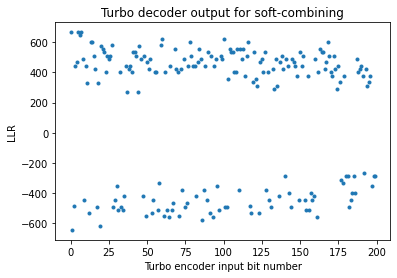

In [466]:
plt.plot(sib1_LLRs, '.')
plt.xlabel('Turbo encoder input bit number')
plt.ylabel('LLR')
plt.title('Turbo decoder output for soft-combining')
plt.show()

In [467]:
# MAP hard decision
pdsch_hard_bytes = np.packbits(sib1_LLRs < 0)

### CRC: 
24 parity bits

In [468]:
class CRC24A_Table:
    "Table driven CRC computation for CRC-24A in LTE"

    def __init__(self, crc_poly):
        "Compute the lookup table for byte-wise divisions"
        self.crc_poly = crc_poly

        # Lookup table for 256 possible byte values, each producing a 24-bit CRC
        self._t = np.zeros(256, dtype=np.uint32)  # 24-bit CRC, so we need a 32-bit data type
        mask = np.uint32(1 << 23)  # The 24th bit mask for CRC-24A

        # Populate the lookup table
        for n in np.arange(256, dtype=np.uint32):
            c = n << 16  # Shift the byte to the top of 24 bits (since CRC-24A works with 24 bits)
            for k in range(8):  # Process each bit
                if ((c & mask) != 0):  # If the top bit is set
                    c = crc_poly ^ (c << 1)  # XOR with the polynomial and shift left
                else:
                    c = c << 1  # Just shift left if no XOR is needed
            self._t[n] = c & 0xFFFFFF  # Mask to 24 bits and store in the table

    def _update_crc(self, byte, prev_crc):
        "Update the CRC for a single byte"
        # Get the top byte of the current CRC and XOR with the current byte
        table_index = ((prev_crc >> 16) ^ byte) & 0xFF
        # Shift the CRC left by 8 bits and XOR with the value from the table
        return ((prev_crc << 8) ^ self._t[table_index]) & 0xFFFFFF

    def __call__(self, data):
        """
        Computes the CRC-24A of the given data (in bytes).
        
        Input:
        * data - vector of bytes (uint8)

        Returns:
        integer containing the CRC-24A checksum.
        """
        crc = np.uint32(0x000000)  # CRC-24A initial value (0x000000)

        for byte in data:
            crc = self._update_crc(byte, crc)

        return crc & 0xFFFFFF  # Return the final CRC-24A value

### Checking the Received Bits

In [469]:
crc = CRC24A_Table(0x864CFB)

crc_match = False

if crc(pdsch_hard_bytes) == 0:
    crc_match = True
    
if crc_match:
    SIB1_bytes = pdsch_hard_bytes[:-3]
    print('Found SIB1 in bytes: {:}'.format(SIB1_bytes))
else:
    print('no valid SIB1 found.')

Found SIB1 in bytes: [ 96  72  80  15 112   1  70 101 177  88  35  84 198   2   6  16 176 137
 132 111  64   0]


#### Decode the SIB1

In [470]:
asn1.decode('BCCH-DL-SCH-Message', SIB1_bytes)

{'message': ('c1',
  ('systemInformationBlockType1',
   {'cellAccessRelatedInfo': {'plmn-IdentityList': [{'plmn-Identity': {'mcc': [2,
         1,
         4],
        'mnc': [0, 7]},
       'cellReservedForOperatorUse': 'notReserved'}],
     'trackingAreaCode': (b'p\x01', 16),
     'cellIdentity': (b'Fe\xb1P', 28),
     'cellBarred': 'notBarred',
     'intraFreqReselection': 'allowed',
     'csg-Indication': False},
    'cellSelectionInfo': {'q-RxLevMin': -62},
    'p-Max': 23,
    'freqBandIndicator': 20,
    'schedulingInfoList': [{'si-Periodicity': 'rf8',
      'sib-MappingInfo': ['sibType3']},
     {'si-Periodicity': 'rf64', 'sib-MappingInfo': ['sibType4']},
     {'si-Periodicity': 'rf64', 'sib-MappingInfo': ['sibType5']},
     {'si-Periodicity': 'rf64', 'sib-MappingInfo': ['sibType6']}],
    'si-WindowLength': 'ms10',
    'systemInfoValueTag': 26}))}

## Task 6 (Detour): Decode the second user data in the PDSCH
It is shown in the spectrogram of subframe 5 that there is another bright region that carries transmitted information.

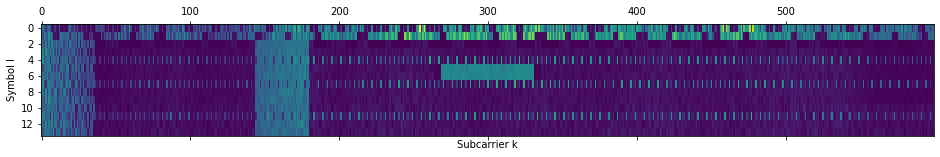

In [471]:
plt.matshow(np.abs(subf5),aspect='auto')
plt.xlabel('Subcarrier k')
plt.ylabel('Symbol l')

plt.show()

It is also shown there is another potential DCI that is aggregated in PDCCH.

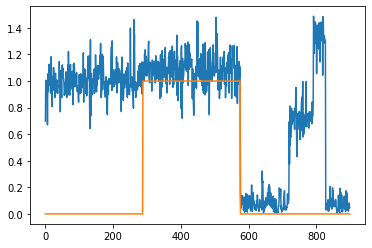

In [472]:
win = np.zeros_like(x_pdcch)
plt.plot(np.abs(x_pdcch))

win[8*36:16*36] = 1
plt.plot(np.abs(win))

plt.show()

#### Rate Matching

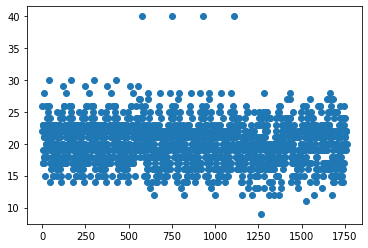

The distance between repeated DCI: [576, 753, 930, 1107]


In [473]:
# look at correlations for different portion of pdcch bits.
st_re = 8*2*CCE
wl = 40 # window size 
pdcch_f = pdcch_bits[st_re:st_re+wl]
corr = []

win = 0
while win <= len(pdcch_bits)-wl:
    corr.append(wl-np.sum(pdcch_f ^ pdcch_bits[win:win+wl])) 
    win += 1
    
plt.plot(corr,'o')
plt.show()

print('The distance between repeated DCI: {:}'.format([i for i, x in enumerate(corr) if x == 40]))

#### Extract the DCI bits before bit collection and pruning

In [474]:
l_dci_3x = 177

l_dci = l_dci_3x//3

dci_bits = pdcch_bits[st_re:st_re+l_dci_3x]

#### Subblock Interleaver

In [475]:
col_perm_table = np.array([1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31, 
                           0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30])

ind  = np.arange(l_dci)                
perm_table = subblock_interleaver(ind,col_perm_table) 

dci_coded_bits = np.zeros((3,l_dci),dtype=np.uint8)

for n in range(3):
    dci_coded_bits[n,perm_table] = dci_bits[n*l_dci:(n+1)*l_dci] 

#### FEC

In [476]:
fec = ConvCoder([0o133, 0o171, 0o165])
dci_hard_bits, cost = fec.decode(dci_coded_bits,hamming_dist)

print("cost = {:f}, bits = {:}".format(cost, dci_hard_bits))

cost = 0.000000, bits = [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0]


#### CRC: 
One thing should be noted: the 16 parity bits are scrambled by RNTI.

The value of RNTI can be checked in TS 36.321 7.1.

In [477]:
crc = CRC16_Table(0x1021)

n_dci = l_dci-16

dci_bits = dci_hard_bits[:n_dci]

crc_match = False

for rnti in range(0xFFFF+1):
    parity_bits = dci_hard_bits[n_dci:] ^ [int(b) for b in bin(rnti)[2:].zfill(16)]

    pdcch_crc_bits = np.concatenate([dci_bits,parity_bits])

    bytes = np.packbits(pdcch_crc_bits)

    if crc(bytes) == 0:
        crc_match = True
        break
    
    
if crc_match:
    print('Found DCI: {:}. The scrambled RNTI is {:}'.format(
                                            dci_bits,hex(rnti)))
else:
    print('no valid DCI found.')

Found DCI: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 1 0]. The scrambled RNTI is 0x1f15


The scrambled RNTI is 0x1f15, according to TS 36.321 7.1, it corresponds to C-RNTI.

The following information can be read from the above DCI:
- Its format is DCI format 2 scrambled by C-RNTI
- It occupies three resource blocks starting from 12 to 14
- Its modulation type is QPSK.
- It points to transport block size equaling to 88
- Its redundancy version is 0

### Decode the corresponding data in PDSCH

In [478]:
# SIB1 information from decoded DCI
rb_pdsch_start = 12
N_rb_pdsch = 3
TBS = 88
rv = 0

#### Extract the data

In [479]:
tmp0 = np.zeros((14,12*N_rb_dl),complex)
tmp1 = np.zeros((14,12*N_rb_dl),complex)

# define mask for positions of CRS
ex_index = np.arange(0,N_rb_pdsch*12,3)
mask = np.ones(N_rb_pdsch*12,dtype=bool)
mask[ex_index] = False

r_pdsch = np.array([], dtype=complex)
h0_pdsch = np.array([], dtype=complex)
h1_pdsch = np.array([], dtype=complex) 

for l in range(14):
    # intepolate in time domain for entire PDSCH. In one slot,
    # CRS at symbol 0 for symbols 0 to 3, 4 for symbols 4 to 6.
    if l < 4:
        tmp0[l,:] = h_subf5[0][0]
        tmp1[l,:] = h_subf5[1][0]
    elif l < 7:
        tmp0[l,:] = h_subf5[0][1]
        tmp1[l,:] = h_subf5[1][1]
    elif l < 11:
        tmp0[l,:] = h_subf5[0][2]
        tmp1[l,:] = h_subf5[1][2]
    else:
        tmp0[l,:] = h_subf5[0][3]
        tmp1[l,:] = h_subf5[1][3]
        
    # extract resource elements for sib1 (excluding CRS)   
    if l >= CFI:
        tmp = subf5[l][rb_pdsch_start*12:(rb_pdsch_start+N_rb_pdsch)*12]
        h_tmp0 = tmp0[l][rb_pdsch_start*12:(rb_pdsch_start+N_rb_pdsch)*12]
        h_tmp1 = tmp1[l][rb_pdsch_start*12:(rb_pdsch_start+N_rb_pdsch)*12]
        
        # exclude crs
        if l in [0,4,7,11]:
            r_pdsch = np.concatenate((r_pdsch,tmp[mask]))
            h0_pdsch = np.concatenate((h0_pdsch,h_tmp0[mask]))
            h1_pdsch = np.concatenate((h1_pdsch,h_tmp1[mask]))

        else:
            r_pdsch = np.concatenate((r_pdsch,tmp))
            h0_pdsch = np.concatenate((h0_pdsch,h_tmp0))
            h1_pdsch = np.concatenate((h1_pdsch,h_tmp1))

### Layer Mapping and Precoding:

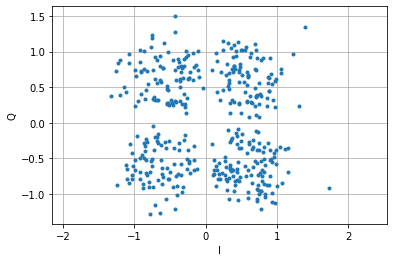

In [480]:
x_pdsch = Alamouti_combine(r_pdsch,h0_pdsch,h1_pdsch)
x_pdsch = x_pdsch*np.exp(-1j*np.pi/11) # phase correction.

plt.plot(x_pdsch.real,x_pdsch.imag,'.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

### QPSK demodulation

In [481]:
pdsch_scrambled_bits = qpsk_demodulate(x_pdsch)

### Soft Scrambling


In [482]:
ns = 10
q = 0 # the number of codewords. 0 or 1.
c_init = (rnti << 14) + (q << 13) + ((ns // 2) << 9) + N_id

c = c_sequence(len(pdsch_scrambled_bits),c_init)

pdsch_bits = pdsch_scrambled_bits * (1.-2*c)

#### Rate Matching

In [483]:
CRC_len = 24
trellis_end = 4
coded_block_size = TBS + CRC_len + trellis_end
collect_len = 3*coded_block_size

ind = np.arange(coded_block_size)
col_perm_table = np.array([0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30,
                           1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31])

perm_table = rate_matching_turbo(ind,col_perm_table,rv)

pdsch_coded_bits = np.zeros(collect_len)
pdsch_coded_bits[perm_table] = pdsch_bits[:collect_len]
pdsch_coded_bits = pdsch_coded_bits.reshape(3,coded_block_size)

### Decode the PDSCH bits

In [484]:
# converts soft input bits to LLR, assuming QPSK and AWGN
pdsch_LLR = np.zeros_like(pdsch_coded_bits)

for n in range(3):
    pdsch_LLR[n,:] = bits_to_LLRs(pdsch_coded_bits[n,:], sib1_noise_sigma)

In [485]:
# According to TS 36.212 Table 5.1.3-3 for K=200
f1 = 41
f2 = 84
user_LLRs = LTE_turbo_decoder(pdsch_LLR, TBS, f1, f2)

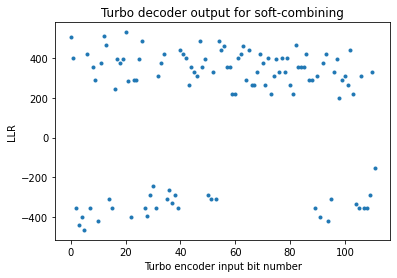

In [486]:
plt.plot(user_LLRs, '.')
plt.xlabel('Turbo encoder input bit number')
plt.ylabel('LLR')
plt.title('Turbo decoder output for soft-combining')
plt.show()

In [491]:
# MAP hard decision
pdsch_hard_bytes = np.packbits(user_LLRs < 0)

### Checking the Received Bits

In [492]:
crc = CRC24A_Table(0x864CFB)

crc_match = False

if crc(pdsch_hard_bytes) == 0:
    crc_match = True
    
if crc_match:
    user_bytes = pdsch_hard_bytes[:-3]
    print('Found other user data in bytes: {:}'.format(user_bytes))
else:
    print('no valid user data found.')

Found other user data in bytes: [61 35  2 31 31  0 52  0  0  0  0]


#### Decode the information

In [493]:
asn1.decode('BCCH-DL-SCH-Message', user_bytes)

{'message': ('c1',
  ('systemInformation',
   {'criticalExtensions': ('criticalExtensionsFuture-r15',
     ('criticalExtensionsFuture', {}))}))}